# **Kaggle challenge** 
## Pokemon classification - Comment Version

---

## *Authors :*

    Courrege Téo
    Gandeel Loaï

### Importing the libraries

In [1]:
!pip install efficientnet_pytorch # install efficientnet - our model

  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d6e83cfbe774b2055fb29bc92f85c16767624cd02d557d27ed994071cdedfb80
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


We will be using the ```efficientnet``` library to train our model. It is a library that contains pretrained models that we can use to train our model. We will be using the ```efficientnetb0``` model.

https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142

In [2]:
import os  # for path operations
import torch # PyTorch
from torch import nn # Neural Network
from torch.optim import Adam # Optimizer
import torch.nn.functional as F # Functional
from torch.nn import Sequential, Conv2d, Module, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms # Transformations
from torchvision.transforms import Lambda # To apply lambda function
from torchvision.models import resnet50, ResNet50_Weights
from efficientnet_pytorch import EfficientNet  # EfficientNet


# For creating the train, validation and test sets
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm # Progress bar
import pandas as pd # Dataframe
from PIL import Image # Image processing
from PIL import ImageFilter
import cv2 # OpenCV

# For the trainning part
from torchvision import models # Models
from torch.optim import lr_scheduler # Learning rate scheduler

# For the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Manipulating to use the 2 GPUs of Kaggle

In [3]:
# List the available devices:
print("Available devices:")
print(torch.cuda.device_count())
print("List of devices:")
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(1))
print(torch.cuda.get_device_name(1))

Available devices:
2
List of devices:
Tesla T4
Tesla T4


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # to use both GPUs

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using {device} device")

## Data
### **Collecting data and preprocessing**

We will primarily be using dictionaries to store our data.

The first pokemon is Golbat and it has 40 images


Text(0.5, 1.0, 'Golbat')

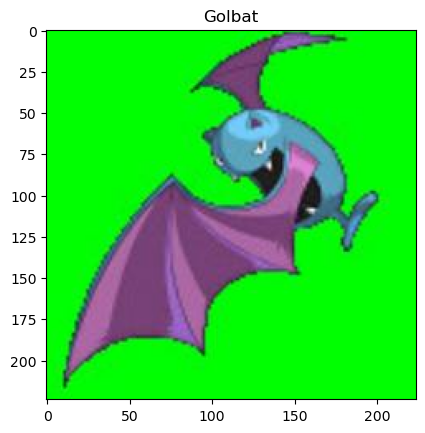

In [6]:
# The path to the directory containing folder with the pokemons name containing their images
train_paths = "/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/trainval"
test_paths = "/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/test"

# Getting the name of each pokemon (the folder's name)
pokemon_names = os.listdir(train_paths)

# Creating a dictionary to map each image to its pokemon name
pokemon_dict = {}
for pokemon in pokemon_names:
    pokemon_dict[pokemon] = os.listdir(train_paths + "/" + pokemon) # key : pokemon name, value : list of image names

# Plot the first image with its pokemon name
print("The first pokemon is " + pokemon_names[0] + " and it has " + str(
    len(pokemon_dict[pokemon_names[0]])) + " images")
plt.imshow(plt.imread(train_paths + "/" +
           pokemon_names[0] + "/" + pokemon_dict[pokemon_names[0]][0]))
plt.title(pokemon_names[0])
# print(pokemon_dict)

In [7]:
pokemon_labels = {}
# In csv file, the first column is the image name and the second column is the pokemon name
# We create a dictionary to map each image to its pokemon name
with open("/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/pokemon_ids.csv", "r") as f:
    # Skip the first line
    next(f) # skip the first line which is the header
    for line in f:
        line = line.strip().split(",") # strip() removes the spaces at the beginning and at the end of the line
        pokemon_labels[line[1]] = line[0] # line[1] is the pokemon name and line[0] is label 

print(pokemon_labels)

{'Bulbasaur': '1', 'Ivysaur': '2', 'Venusaur': '3', 'Charmander': '4', 'Charmeleon': '5', 'Charizard': '6', 'Squirtle': '7', 'Wartortle': '8', 'Blastoise': '9', 'Caterpie': '10', 'Metapod': '11', 'Butterfree': '12', 'Weedle': '13', 'Kakuna': '14', 'Beedrill': '15', 'Pidgey': '16', 'Pidgeotto': '17', 'Pidgeot': '18', 'Rattata': '19', 'Raticate': '20', 'Spearow': '21', 'Fearow': '22', 'Ekans': '23', 'Arbok': '24', 'Pikachu': '25', 'Raichu': '26', 'Sandshrew': '27', 'Sandslash': '28', 'Nidoran_female': '29', 'Nidorina': '30', 'Nidoqueen': '31', 'Nidoran_male': '32', 'Nidorino': '33', 'Nidoking': '34', 'Clefairy': '35', 'Clefable': '36', 'Vulpix': '37', 'Ninetales': '38', 'Jigglypuff': '39', 'Wigglytuff': '40', 'Zubat': '41', 'Golbat': '42', 'Oddish': '43', 'Gloom': '44', 'Vileplume': '45', 'Paras': '46', 'Parasect': '47', 'Venonat': '48', 'Venomoth': '49', 'Diglett': '50', 'Dugtrio': '51', 'Meowth': '52', 'Persian': '53', 'Psyduck': '54', 'Golduck': '55', 'Mankey': '56', 'Primeape': '57',

In [8]:
# print image shape
print(plt.imread(train_paths + "/" +
      pokemon_names[0] + "/" + pokemon_dict[pokemon_names[0]][0]).shape)

size_image = plt.imread(
    train_paths + "/" + pokemon_names[0] + "/" + pokemon_dict[pokemon_names[0]][0]).shape[0]

(224, 224, 3)


### Transformations

We will be using multiple types of transformation in order to train our model.

This will consist in: 
1. A transformation to just resize the images to the same size.
2. A transformation to resize the images and normalize them with a mean and standard deviation of $0.5$.
3. A transformation to change the brightness, contrast and saturation of the images.
4. A transformation to change the brightness, contrast and saturation but furthermore randomly rotate the images (focus on the contrast).
5. A tranfomatino to do the same as the previous transformation but with an inverted values for the saturation and contrast. This transfoamtion will also ramdomly erase some parts of the images and make an affine transformation.
6. A transformation to only detect the edges of the images (using the [Canny filter](https://en.wikipedia.org/wiki/Canny_edge_detector)).
7. A transformation to apply a Gaussian filter on the image (blur the original image).

The idea was to increase the number of images we have to train our model on while training it on sufficiently different images to avoid overfitting. So, we decided to make some kind of progressive transformations with more and more options to train our model on the same differated images.

It would train on a Pikachu image, then on a Pikachu image with a different brightness, then on a Pikachu image with a different brightness and contrast, then a pikachu image with random erasing, ..., then on the pikachu image with only the edges.

We take the risk of overfitting our model on the same images but we think that the different transformations can help making the model more robust to different types of images.

In [9]:
# We create the transform function for our images.

transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.01),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.1, contrast=0.2,
                           saturation=0.1, hue=0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.01),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.1, contrast=0.2,
                           saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=30, translate=(
        0.1, 0.1), scale=(0.8, 1.2), shear=20),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Custom transformation for edge detection
def edge_detection(image):
    """ 
    Detect edges in an image using Canny algorithm
    param image: PIL image
    return: PIL image
    """
    image = np.array(image)
    edges = cv2.Canny(image, 100, 200)
    # Create a 3-channel image
    edges = np.stack([edges, edges, edges], axis=-1)
    return Image.fromarray(edges)

transform_3 = transforms.Compose([
    transforms.Lambda(edge_detection), # creating an image prominent edges
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def gaussian_blur(image):
    """ 
    Apply Gaussian blur to an image
    param image: PIL image
    return: PIL image
    """
    # Convert numpy array to PIL Image
    image = Image.fromarray(image)
    return image.filter(ImageFilter.GaussianBlur(radius=5))

transform_gaussian = transforms.Compose([
    transforms.Lambda(gaussian_blur), # Apply Gaussian blur
    transforms.ToTensor(),
    transforms.Resize((size_image, size_image)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Creating a class to load the data and apply the transformations

In [10]:
class PokemonDataset(Dataset):
    """
    Class to create the dataset
    """

    def __init__(self, paths, pokemon_labels, transform=None):
        """
        param paths: list of paths to the images
        param pokemon_labels: dictionary mapping each pokemon name to its label
        param transform: transformation to apply to the images
        """
        self.paths = paths
        self.pokemon_labels = pokemon_labels
        self.transform = transform

    def __len__(self):
        """
        Return the length of the dataset
        param: None
        return: length of the dataset
        """
        return len(self.paths)

    def __getitem__(self, index):
        """
        Return the image and the label of the image at the given index
        param index: index of the image
        return: image, label
        """
        # Getting the pokemon name from the path
        pokemon_name = self.paths[index].split("/")[-2]
        # Getting the image
        image = plt.imread(self.paths[index])
        # if the image is of shape (x, x, 4) open it with PIL and convert it to RGB
        if image.shape[2] == 4:
            image = Image.open(self.paths[index]).convert("RGB")
            image = np.array(image)
        # Transforming the image
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = transform_basic(image)
        # Getting the label
        if pokemon_name == "test":
            label = -1
        else:
            label = self.pokemon_labels[pokemon_name]
        # Return the image, the label and the file name
        return image, label, self.paths[index].split("/")[-1]

### Creating the datasets

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (curre

torch.Size([3, 224, 224])
1000
/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/trainval/*/*.jpg


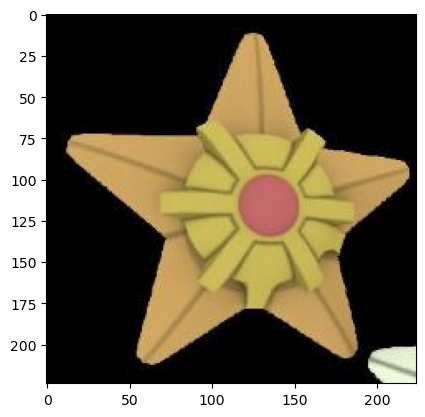

In [11]:
# Creating the train dataset with different transformations
train_val_dataset = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform_basic)

train_val_dataset_1 = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform)

train_val_dataset_2 = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform_1)

train_val_dataset_3 = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform_2)

train_val_dataset_4 = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform_3)

train_val_dataset_5 = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform_4)

train_val_dataset_6 = PokemonDataset(
    glob.glob(train_paths + "/*/*.jpg"), pokemon_labels, transform_gaussian)

# Splitting the datasets into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [int(
    len(train_val_dataset) * 0.8), int(len(train_val_dataset) * 0.2) + 1])

# Creating the test dataset
test_dataset = PokemonDataset(
    glob.glob(test_paths + "/*.jpg"), pokemon_labels, transform_basic)

# Plotting the first image of the train dataset
print(train_dataset[0][0].shape)
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

print(len(test_dataset))
print(train_paths + "/*/*.jpg")

In [12]:
# Creating the train dataloader
# Concatenating the 6 dataloaders
BATCH_SIZE = 64

# Creating the train dataloader by concatenating all of the transformed sets
train_dataloader = DataLoader(
    ConcatDataset(
        [train_val_dataset, train_val_dataset_1, train_val_dataset_2, train_val_dataset_3, train_val_dataset_4, train_val_dataset_5, train_val_dataset_6]),
    batch_size=BATCH_SIZE, shuffle=True)

# Creating the validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) # No need to increase the computation operations with the transformed dataset as we only want to see the result in the validation set


# Creating the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

659
19
16


The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label of 50th image in train dataset:  6


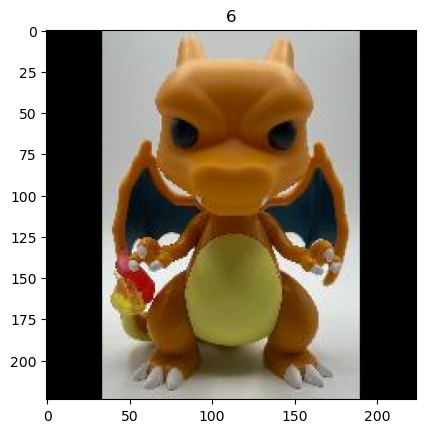

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [13]:
print('The shape of tensor for 50th image in train dataset: ',
      train_dataset[50][0].shape)
print('The label of 50th image in train dataset: ', train_dataset[50][1])
plt.imshow(train_dataset[50][0].permute(1, 2, 0))
plt.title(train_dataset[50][1])
plt.show()
print(train_dataset[50][0])

The shape of tensor for 50th image in test dataset:  torch.Size([3, 224, 224])
The label of 50th image in test dataset:  -1


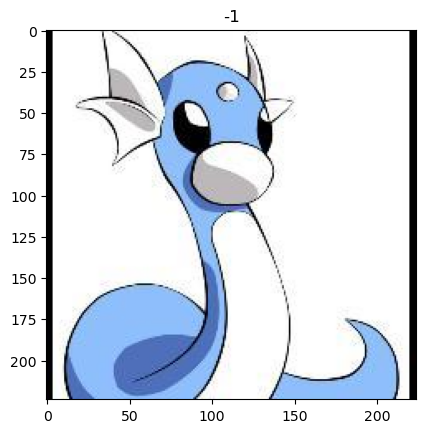

In [14]:
print('The shape of tensor for 50th image in test dataset: ',
      test_dataset[50][0].shape)
print('The label of 50th image in test dataset: ', test_dataset[50][1])
plt.imshow(test_dataset[50][0].permute(1, 2, 0))
plt.title(test_dataset[50][1])
plt.show()

label : 138
file name : 5236.jpg


Text(0.5, 1.0, '138')

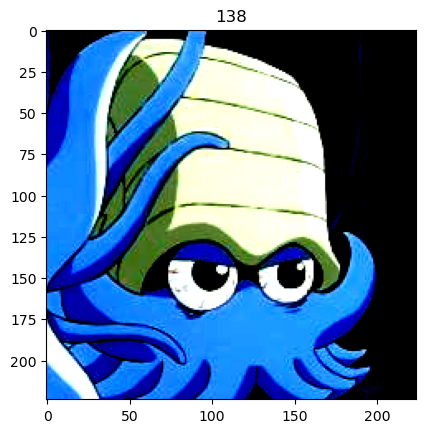

In [15]:
# We show an image of our dataset to see if everything has worked correctly
train_features, train_labels, train_filenames = next(iter(train_dataloader))
# test_features, test_labels = next(iter(test_loader))

# We need to permute dimension to have a (224,224,3) image for the display
print(f'label : {train_labels[0]}')
print(f'file name : {train_filenames[0]}')
plt.imshow(train_features[0].permute(1, 2, 0))
plt.title(train_labels[0])

## Network
### **Building the network**

We opted for the [utilization](https://paperswithcode.com/method/efficientnet) of a model known as [```efficientnet-b0```](https://arxiv.org/abs/1905.11946). This model is comprised of several convolutional layers and concludes with a fully connected layer. The architecture involves the repetition of convolutional blocks called [```MbConvBlock```](https://paperswithcode.com/method/inverted-residual-block), each of which is an inverted residual bottleneck block featuring depth-wise separable convolution. In this process, the input's depth is initially decreased through a 1x1 convolution, followed by the application of a 3x3 convolution to the reduced-depth input. The output of this convolution is then expanded back to the original depth through another 1x1 depth-wise convolution. The output of this process is then added to the input, and the result is passed through a non-linear activation function. The output of this activation function is then passed through a squeeze and excitation layer.

The [squeeze and excitation layer](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7) being a layer that will reduce the number of channels of the input and then increase it again. It will then multiply the output of the convolutional layer by the output of the squeeze and excitation layer. This will help the model to focus on the most important features of the image (a bit like the attention mechanism).

Our network will be composed of a pretrained model (efficientnetb0). We will also be using the ```nn.DataParallel``` class to use the 2 GPUs of Kaggle.

We tried to change the last layer of the model by a linear layer with ```len(classes)``` outputs (cuda problems).

In [16]:
class PokemonDetector(nn.Module):
    def __init__(self, model_name='efficientnet-b0', num_classes=len(pokemon_names)):  # num_classes should be the number of classes in your dataset
        super(PokemonDetector, self).__init__()
        if model_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
        elif model_name == 'efficientnet-b0':
            self.model = EfficientNet.from_pretrained(model_name)

        self.model = nn.DataParallel(self.model)
        self.model = self.model.cuda()

    def forward(self, x):
        return self.model(x)

### Defining the optimizer, the learning rate scheduler and the loss function

We chose to use the ```Adam``` optimizer with an initial learning rate of $0.001$ as it is the one that gave us the best results empirically.

At the first glance, we observed that the loss was decreasing very fast until the $5^{th}$-$7^{th}$ epoch where it started to decrease """very""" slowly. SO we had the idea to decrease the learning rate after the $5^{th}$ epoch.
We chose to use a learning rate scheduler that decreases the learning rate by a factor of $0.1$ every 5 epochs because we saw that after 5 epochs, the loss was not decreasing much anymore.

For this classification problem, we chose to use the ```CrossEntropyLoss``` loss function (after having tried the ```BCEWithLogitsLoss``` loss function).

In [17]:
model = PokemonDetector(model_name='efficientnet-b0', num_classes=len(pokemon_names))

# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define a learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define the loss function
loss_fct = nn.CrossEntropyLoss()
loss_fct = loss_fct.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 155MB/s] 


Loaded pretrained weights for efficientnet-b0


### **Training and validation**

In [18]:
loss_reccord = []

In [19]:
num_epochs = 11 # number of epochs to train the model
for epoch in range(num_epochs):

    model.train()
    for i, (inputs, labels, filenames) in enumerate(tqdm(train_dataloader)):

        optimizer.zero_grad()
        inputs = inputs.cuda()
        labels = [int(labels[i]) for i in range(len(labels))]
        # Move labels to the CUDA device
        labels = torch.tensor(labels, dtype=torch.long).cuda() # convert labels to tensor in order to use them in loss function
        
        outputs = model(inputs)

        loss = loss_fct(outputs, labels)
        loss.backward()
        loss_reccord.append(loss.item())

        optimizer.step()

        if (i + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            
   
    # Step the scheduler
    exp_lr_scheduler.step()

    # Print the current learning rate
    print(f"Epoch [{epoch + 1}/{num_epochs}], Learning Rate: {optimizer.param_groups[0]['lr']}")
    
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels, filenames in tqdm(val_dataloader):

            inputs = inputs.cuda()  # Ensure inputs are on the CUDA device
            outputs = model(inputs)

            labels = [int(labels[i]) for i in range(len(labels))]
            # Move labels to the CUDA device
            labels = torch.tensor(labels, dtype=torch.long).cuda() # convert labels to tensor in order to use them in loss function

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()
        accuracy = 100 * correct / total
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%")

  2%|▏         | 10/659 [00:24<13:58,  1.29s/it]

Epoch [1/11], Batch [10/659], Loss: 7.0509


  3%|▎         | 20/659 [00:35<11:06,  1.04s/it]

Epoch [1/11], Batch [20/659], Loss: 7.2511


  5%|▍         | 30/659 [00:45<11:06,  1.06s/it]

Epoch [1/11], Batch [30/659], Loss: 7.0188


  6%|▌         | 40/659 [00:55<10:09,  1.02it/s]

Epoch [1/11], Batch [40/659], Loss: 6.5766


  8%|▊         | 50/659 [01:05<09:49,  1.03it/s]

Epoch [1/11], Batch [50/659], Loss: 6.3675


  9%|▉         | 60/659 [01:15<10:11,  1.02s/it]

Epoch [1/11], Batch [60/659], Loss: 6.2187


 11%|█         | 70/659 [01:25<09:45,  1.01it/s]

Epoch [1/11], Batch [70/659], Loss: 5.7157


 12%|█▏        | 80/659 [01:35<09:03,  1.06it/s]

Epoch [1/11], Batch [80/659], Loss: 5.7961


 14%|█▎        | 90/659 [01:44<08:49,  1.07it/s]

Epoch [1/11], Batch [90/659], Loss: 5.4679


 15%|█▌        | 100/659 [01:53<08:16,  1.13it/s]

Epoch [1/11], Batch [100/659], Loss: 5.3605


 17%|█▋        | 110/659 [02:02<08:04,  1.13it/s]

Epoch [1/11], Batch [110/659], Loss: 5.0190


 18%|█▊        | 120/659 [02:11<07:44,  1.16it/s]

Epoch [1/11], Batch [120/659], Loss: 4.9597


 20%|█▉        | 130/659 [02:20<07:50,  1.13it/s]

Epoch [1/11], Batch [130/659], Loss: 4.7447


 21%|██        | 140/659 [02:28<07:17,  1.19it/s]

Epoch [1/11], Batch [140/659], Loss: 4.0775


 23%|██▎       | 150/659 [02:37<07:09,  1.19it/s]

Epoch [1/11], Batch [150/659], Loss: 4.0463


 24%|██▍       | 160/659 [02:45<06:43,  1.24it/s]

Epoch [1/11], Batch [160/659], Loss: 4.0662


 26%|██▌       | 170/659 [02:53<06:41,  1.22it/s]

Epoch [1/11], Batch [170/659], Loss: 3.6424


 27%|██▋       | 180/659 [03:01<06:23,  1.25it/s]

Epoch [1/11], Batch [180/659], Loss: 3.6320


 29%|██▉       | 190/659 [03:09<06:20,  1.23it/s]

Epoch [1/11], Batch [190/659], Loss: 3.6393


 30%|███       | 200/659 [03:17<05:52,  1.30it/s]

Epoch [1/11], Batch [200/659], Loss: 3.5562


 32%|███▏      | 210/659 [03:25<06:00,  1.24it/s]

Epoch [1/11], Batch [210/659], Loss: 2.9816


 33%|███▎      | 220/659 [03:33<06:07,  1.20it/s]

Epoch [1/11], Batch [220/659], Loss: 3.0031


 35%|███▍      | 230/659 [03:41<05:50,  1.23it/s]

Epoch [1/11], Batch [230/659], Loss: 2.6613


 36%|███▋      | 240/659 [03:49<05:40,  1.23it/s]

Epoch [1/11], Batch [240/659], Loss: 2.6817


 38%|███▊      | 250/659 [03:57<05:17,  1.29it/s]

Epoch [1/11], Batch [250/659], Loss: 2.5608


 39%|███▉      | 260/659 [04:05<04:52,  1.37it/s]

Epoch [1/11], Batch [260/659], Loss: 2.6713


 41%|████      | 270/659 [04:12<04:51,  1.33it/s]

Epoch [1/11], Batch [270/659], Loss: 2.7196


 42%|████▏     | 280/659 [04:20<04:47,  1.32it/s]

Epoch [1/11], Batch [280/659], Loss: 1.9567


 44%|████▍     | 290/659 [04:27<04:39,  1.32it/s]

Epoch [1/11], Batch [290/659], Loss: 2.4108


 46%|████▌     | 300/659 [04:35<04:43,  1.27it/s]

Epoch [1/11], Batch [300/659], Loss: 1.7060


 47%|████▋     | 310/659 [04:43<04:24,  1.32it/s]

Epoch [1/11], Batch [310/659], Loss: 1.9556


 49%|████▊     | 320/659 [04:50<04:10,  1.36it/s]

Epoch [1/11], Batch [320/659], Loss: 1.6607


 50%|█████     | 330/659 [04:58<04:06,  1.33it/s]

Epoch [1/11], Batch [330/659], Loss: 1.4756


 52%|█████▏    | 340/659 [05:06<04:02,  1.32it/s]

Epoch [1/11], Batch [340/659], Loss: 1.8146


 53%|█████▎    | 350/659 [05:13<03:53,  1.32it/s]

Epoch [1/11], Batch [350/659], Loss: 1.4860


 55%|█████▍    | 360/659 [05:21<03:42,  1.34it/s]

Epoch [1/11], Batch [360/659], Loss: 1.4290


 56%|█████▌    | 370/659 [05:29<03:51,  1.25it/s]

Epoch [1/11], Batch [370/659], Loss: 1.8615


 58%|█████▊    | 380/659 [05:36<03:26,  1.35it/s]

Epoch [1/11], Batch [380/659], Loss: 1.5839


 59%|█████▉    | 390/659 [05:44<03:13,  1.39it/s]

Epoch [1/11], Batch [390/659], Loss: 1.4158


 61%|██████    | 400/659 [05:51<03:29,  1.24it/s]

Epoch [1/11], Batch [400/659], Loss: 1.6846


 62%|██████▏   | 410/659 [05:59<03:15,  1.27it/s]

Epoch [1/11], Batch [410/659], Loss: 1.4200


 64%|██████▎   | 420/659 [06:07<02:51,  1.40it/s]

Epoch [1/11], Batch [420/659], Loss: 1.1894


 65%|██████▌   | 430/659 [06:14<02:47,  1.37it/s]

Epoch [1/11], Batch [430/659], Loss: 1.0606


 67%|██████▋   | 440/659 [06:22<02:53,  1.26it/s]

Epoch [1/11], Batch [440/659], Loss: 1.2860


 68%|██████▊   | 450/659 [06:30<03:00,  1.15it/s]

Epoch [1/11], Batch [450/659], Loss: 1.3317


 70%|██████▉   | 460/659 [06:37<02:32,  1.30it/s]

Epoch [1/11], Batch [460/659], Loss: 1.2091


 71%|███████▏  | 470/659 [06:44<02:13,  1.41it/s]

Epoch [1/11], Batch [470/659], Loss: 1.2964


 73%|███████▎  | 480/659 [06:52<02:13,  1.34it/s]

Epoch [1/11], Batch [480/659], Loss: 1.2098


 74%|███████▍  | 490/659 [06:59<02:11,  1.29it/s]

Epoch [1/11], Batch [490/659], Loss: 1.1003


 76%|███████▌  | 500/659 [07:07<01:58,  1.34it/s]

Epoch [1/11], Batch [500/659], Loss: 1.2207


 77%|███████▋  | 510/659 [07:14<01:48,  1.38it/s]

Epoch [1/11], Batch [510/659], Loss: 1.1816


 79%|███████▉  | 520/659 [07:22<01:46,  1.30it/s]

Epoch [1/11], Batch [520/659], Loss: 1.1457


 80%|████████  | 530/659 [07:30<01:40,  1.28it/s]

Epoch [1/11], Batch [530/659], Loss: 1.0507


 82%|████████▏ | 540/659 [07:37<01:29,  1.32it/s]

Epoch [1/11], Batch [540/659], Loss: 1.1477


 83%|████████▎ | 550/659 [07:45<01:20,  1.35it/s]

Epoch [1/11], Batch [550/659], Loss: 1.1272


 85%|████████▍ | 560/659 [07:53<01:16,  1.29it/s]

Epoch [1/11], Batch [560/659], Loss: 1.2079


 86%|████████▋ | 570/659 [08:00<01:06,  1.34it/s]

Epoch [1/11], Batch [570/659], Loss: 1.0595


 88%|████████▊ | 580/659 [08:08<00:58,  1.36it/s]

Epoch [1/11], Batch [580/659], Loss: 1.1201


 90%|████████▉ | 590/659 [08:15<00:49,  1.38it/s]

Epoch [1/11], Batch [590/659], Loss: 1.0640


 91%|█████████ | 600/659 [08:23<00:46,  1.28it/s]

Epoch [1/11], Batch [600/659], Loss: 0.8672


 93%|█████████▎| 610/659 [08:30<00:35,  1.40it/s]

Epoch [1/11], Batch [610/659], Loss: 0.7868


 94%|█████████▍| 620/659 [08:37<00:29,  1.30it/s]

Epoch [1/11], Batch [620/659], Loss: 0.5234


 96%|█████████▌| 630/659 [08:45<00:21,  1.33it/s]

Epoch [1/11], Batch [630/659], Loss: 0.8310


 97%|█████████▋| 640/659 [08:53<00:14,  1.30it/s]

Epoch [1/11], Batch [640/659], Loss: 0.9780


 99%|█████████▊| 650/659 [09:00<00:06,  1.29it/s]

Epoch [1/11], Batch [650/659], Loss: 0.7034


100%|██████████| 659/659 [09:07<00:00,  1.20it/s]


Epoch [1/11], Learning Rate: 0.0001


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


Epoch [1/11], Validation Accuracy: 96.10%


  2%|▏         | 10/659 [00:07<07:55,  1.37it/s]

Epoch [2/11], Batch [10/659], Loss: 0.9823


  3%|▎         | 20/659 [00:14<08:22,  1.27it/s]

Epoch [2/11], Batch [20/659], Loss: 0.6467


  5%|▍         | 30/659 [00:22<07:42,  1.36it/s]

Epoch [2/11], Batch [30/659], Loss: 0.6686


  6%|▌         | 40/659 [00:30<07:50,  1.32it/s]

Epoch [2/11], Batch [40/659], Loss: 0.6263


  8%|▊         | 50/659 [00:38<07:45,  1.31it/s]

Epoch [2/11], Batch [50/659], Loss: 0.8706


  9%|▉         | 60/659 [00:45<07:09,  1.40it/s]

Epoch [2/11], Batch [60/659], Loss: 0.5963


 11%|█         | 70/659 [00:53<07:49,  1.25it/s]

Epoch [2/11], Batch [70/659], Loss: 0.8975


 12%|█▏        | 80/659 [01:00<07:10,  1.35it/s]

Epoch [2/11], Batch [80/659], Loss: 0.4616


 14%|█▎        | 90/659 [01:08<06:53,  1.38it/s]

Epoch [2/11], Batch [90/659], Loss: 0.5875


 15%|█▌        | 100/659 [01:15<06:48,  1.37it/s]

Epoch [2/11], Batch [100/659], Loss: 0.7128


 17%|█▋        | 110/659 [01:23<07:13,  1.27it/s]

Epoch [2/11], Batch [110/659], Loss: 0.6934


 18%|█▊        | 120/659 [01:31<06:32,  1.37it/s]

Epoch [2/11], Batch [120/659], Loss: 0.5738


 20%|█▉        | 130/659 [01:38<06:38,  1.33it/s]

Epoch [2/11], Batch [130/659], Loss: 0.6452


 21%|██        | 140/659 [01:45<06:29,  1.33it/s]

Epoch [2/11], Batch [140/659], Loss: 0.5477


 23%|██▎       | 150/659 [01:53<06:20,  1.34it/s]

Epoch [2/11], Batch [150/659], Loss: 0.7967


 24%|██▍       | 160/659 [02:01<06:26,  1.29it/s]

Epoch [2/11], Batch [160/659], Loss: 0.5952


 26%|██▌       | 170/659 [02:08<05:50,  1.40it/s]

Epoch [2/11], Batch [170/659], Loss: 0.6851


 27%|██▋       | 180/659 [02:15<06:10,  1.29it/s]

Epoch [2/11], Batch [180/659], Loss: 0.5272


 29%|██▉       | 190/659 [02:23<05:38,  1.39it/s]

Epoch [2/11], Batch [190/659], Loss: 0.5251


 30%|███       | 200/659 [02:31<06:04,  1.26it/s]

Epoch [2/11], Batch [200/659], Loss: 0.3218


 32%|███▏      | 210/659 [02:38<05:24,  1.38it/s]

Epoch [2/11], Batch [210/659], Loss: 0.3707


 33%|███▎      | 220/659 [02:46<05:26,  1.35it/s]

Epoch [2/11], Batch [220/659], Loss: 0.5461


 35%|███▍      | 230/659 [02:53<05:27,  1.31it/s]

Epoch [2/11], Batch [230/659], Loss: 0.5001


 36%|███▋      | 240/659 [03:00<05:16,  1.32it/s]

Epoch [2/11], Batch [240/659], Loss: 0.3231


 38%|███▊      | 250/659 [03:08<05:09,  1.32it/s]

Epoch [2/11], Batch [250/659], Loss: 0.3649


 39%|███▉      | 260/659 [03:16<04:58,  1.33it/s]

Epoch [2/11], Batch [260/659], Loss: 0.6811


 41%|████      | 270/659 [03:23<04:58,  1.30it/s]

Epoch [2/11], Batch [270/659], Loss: 0.5834


 42%|████▏     | 280/659 [03:31<04:39,  1.36it/s]

Epoch [2/11], Batch [280/659], Loss: 0.4841


 44%|████▍     | 290/659 [03:39<04:36,  1.33it/s]

Epoch [2/11], Batch [290/659], Loss: 0.5993


 46%|████▌     | 300/659 [03:46<04:37,  1.29it/s]

Epoch [2/11], Batch [300/659], Loss: 0.5719


 47%|████▋     | 310/659 [03:53<04:16,  1.36it/s]

Epoch [2/11], Batch [310/659], Loss: 0.5008


 49%|████▊     | 320/659 [04:01<04:20,  1.30it/s]

Epoch [2/11], Batch [320/659], Loss: 0.3118


 50%|█████     | 330/659 [04:09<04:16,  1.28it/s]

Epoch [2/11], Batch [330/659], Loss: 0.5129


 52%|█████▏    | 340/659 [04:17<04:21,  1.22it/s]

Epoch [2/11], Batch [340/659], Loss: 0.4352


 53%|█████▎    | 350/659 [04:24<03:59,  1.29it/s]

Epoch [2/11], Batch [350/659], Loss: 0.6364


 55%|█████▍    | 360/659 [04:32<03:44,  1.33it/s]

Epoch [2/11], Batch [360/659], Loss: 0.5881


 56%|█████▌    | 370/659 [04:40<03:57,  1.22it/s]

Epoch [2/11], Batch [370/659], Loss: 0.4575


 58%|█████▊    | 380/659 [04:47<03:31,  1.32it/s]

Epoch [2/11], Batch [380/659], Loss: 0.4936


 59%|█████▉    | 390/659 [04:55<03:24,  1.32it/s]

Epoch [2/11], Batch [390/659], Loss: 0.5788


 61%|██████    | 400/659 [05:02<03:24,  1.27it/s]

Epoch [2/11], Batch [400/659], Loss: 0.4425


 62%|██████▏   | 410/659 [05:10<03:12,  1.29it/s]

Epoch [2/11], Batch [410/659], Loss: 0.5470


 64%|██████▎   | 420/659 [05:18<03:01,  1.32it/s]

Epoch [2/11], Batch [420/659], Loss: 0.7528


 65%|██████▌   | 430/659 [05:25<02:58,  1.29it/s]

Epoch [2/11], Batch [430/659], Loss: 0.4973


 67%|██████▋   | 440/659 [05:33<02:47,  1.30it/s]

Epoch [2/11], Batch [440/659], Loss: 0.3608


 68%|██████▊   | 450/659 [05:40<02:40,  1.30it/s]

Epoch [2/11], Batch [450/659], Loss: 0.2346


 70%|██████▉   | 460/659 [05:48<02:29,  1.33it/s]

Epoch [2/11], Batch [460/659], Loss: 0.6144


 71%|███████▏  | 470/659 [05:55<02:21,  1.34it/s]

Epoch [2/11], Batch [470/659], Loss: 0.5608


 73%|███████▎  | 480/659 [06:03<02:09,  1.39it/s]

Epoch [2/11], Batch [480/659], Loss: 0.2235


 74%|███████▍  | 490/659 [06:10<02:04,  1.36it/s]

Epoch [2/11], Batch [490/659], Loss: 0.3362


 76%|███████▌  | 500/659 [06:18<01:58,  1.35it/s]

Epoch [2/11], Batch [500/659], Loss: 0.3115


 77%|███████▋  | 510/659 [06:25<01:44,  1.43it/s]

Epoch [2/11], Batch [510/659], Loss: 0.3347


 79%|███████▉  | 520/659 [06:32<01:41,  1.37it/s]

Epoch [2/11], Batch [520/659], Loss: 0.5143


 80%|████████  | 530/659 [06:40<01:39,  1.30it/s]

Epoch [2/11], Batch [530/659], Loss: 0.3839


 82%|████████▏ | 540/659 [06:47<01:31,  1.30it/s]

Epoch [2/11], Batch [540/659], Loss: 0.4889


 83%|████████▎ | 550/659 [06:55<01:19,  1.38it/s]

Epoch [2/11], Batch [550/659], Loss: 0.4461


 85%|████████▍ | 560/659 [07:02<01:10,  1.40it/s]

Epoch [2/11], Batch [560/659], Loss: 0.4882


 86%|████████▋ | 570/659 [07:09<01:07,  1.33it/s]

Epoch [2/11], Batch [570/659], Loss: 0.4190


 88%|████████▊ | 580/659 [07:17<00:57,  1.38it/s]

Epoch [2/11], Batch [580/659], Loss: 0.5190


 90%|████████▉ | 590/659 [07:24<00:49,  1.38it/s]

Epoch [2/11], Batch [590/659], Loss: 0.3793


 91%|█████████ | 600/659 [07:31<00:42,  1.40it/s]

Epoch [2/11], Batch [600/659], Loss: 0.4842


 93%|█████████▎| 610/659 [07:39<00:36,  1.33it/s]

Epoch [2/11], Batch [610/659], Loss: 0.3199


 94%|█████████▍| 620/659 [07:46<00:31,  1.23it/s]

Epoch [2/11], Batch [620/659], Loss: 0.2509


 96%|█████████▌| 630/659 [07:54<00:22,  1.27it/s]

Epoch [2/11], Batch [630/659], Loss: 0.4120


 97%|█████████▋| 640/659 [08:01<00:13,  1.42it/s]

Epoch [2/11], Batch [640/659], Loss: 0.3598


 99%|█████████▊| 650/659 [08:09<00:07,  1.23it/s]

Epoch [2/11], Batch [650/659], Loss: 0.2966


100%|██████████| 659/659 [08:16<00:00,  1.33it/s]


Epoch [2/11], Learning Rate: 0.0001


100%|██████████| 19/19 [00:05<00:00,  3.52it/s]


Epoch [2/11], Validation Accuracy: 99.09%


  2%|▏         | 10/659 [00:07<08:05,  1.34it/s]

Epoch [3/11], Batch [10/659], Loss: 0.4517


  3%|▎         | 20/659 [00:14<07:41,  1.38it/s]

Epoch [3/11], Batch [20/659], Loss: 0.3745


  5%|▍         | 30/659 [00:22<07:44,  1.36it/s]

Epoch [3/11], Batch [30/659], Loss: 0.2805


  6%|▌         | 40/659 [00:29<08:05,  1.28it/s]

Epoch [3/11], Batch [40/659], Loss: 0.3527


  8%|▊         | 50/659 [00:37<07:45,  1.31it/s]

Epoch [3/11], Batch [50/659], Loss: 0.1865


  9%|▉         | 60/659 [00:44<06:59,  1.43it/s]

Epoch [3/11], Batch [60/659], Loss: 0.1885


 11%|█         | 70/659 [00:52<07:25,  1.32it/s]

Epoch [3/11], Batch [70/659], Loss: 0.2608


 12%|█▏        | 80/659 [01:00<07:38,  1.26it/s]

Epoch [3/11], Batch [80/659], Loss: 0.2946


 14%|█▎        | 90/659 [01:07<07:06,  1.33it/s]

Epoch [3/11], Batch [90/659], Loss: 0.3680


 15%|█▌        | 100/659 [01:15<06:47,  1.37it/s]

Epoch [3/11], Batch [100/659], Loss: 0.3115


 17%|█▋        | 110/659 [01:22<06:51,  1.33it/s]

Epoch [3/11], Batch [110/659], Loss: 0.2032


 18%|█▊        | 120/659 [01:29<06:26,  1.40it/s]

Epoch [3/11], Batch [120/659], Loss: 0.2915


 20%|█▉        | 130/659 [01:37<06:33,  1.35it/s]

Epoch [3/11], Batch [130/659], Loss: 0.3556


 21%|██        | 140/659 [01:45<06:26,  1.34it/s]

Epoch [3/11], Batch [140/659], Loss: 0.1306


 23%|██▎       | 150/659 [01:52<06:06,  1.39it/s]

Epoch [3/11], Batch [150/659], Loss: 0.2275


 24%|██▍       | 160/659 [01:59<06:12,  1.34it/s]

Epoch [3/11], Batch [160/659], Loss: 0.1613


 26%|██▌       | 170/659 [02:08<06:24,  1.27it/s]

Epoch [3/11], Batch [170/659], Loss: 0.2970


 27%|██▋       | 180/659 [02:15<05:41,  1.40it/s]

Epoch [3/11], Batch [180/659], Loss: 0.1732


 29%|██▉       | 190/659 [02:23<06:14,  1.25it/s]

Epoch [3/11], Batch [190/659], Loss: 0.2767


 30%|███       | 200/659 [02:31<06:03,  1.26it/s]

Epoch [3/11], Batch [200/659], Loss: 0.2759


 32%|███▏      | 210/659 [02:39<05:34,  1.34it/s]

Epoch [3/11], Batch [210/659], Loss: 0.3017


 33%|███▎      | 220/659 [02:46<05:23,  1.36it/s]

Epoch [3/11], Batch [220/659], Loss: 0.4040


 35%|███▍      | 230/659 [02:54<05:15,  1.36it/s]

Epoch [3/11], Batch [230/659], Loss: 0.1869


 36%|███▋      | 240/659 [03:01<05:18,  1.32it/s]

Epoch [3/11], Batch [240/659], Loss: 0.3116


 38%|███▊      | 250/659 [03:09<05:15,  1.30it/s]

Epoch [3/11], Batch [250/659], Loss: 0.4372


 39%|███▉      | 260/659 [03:16<05:06,  1.30it/s]

Epoch [3/11], Batch [260/659], Loss: 0.2331


 41%|████      | 270/659 [03:24<04:47,  1.35it/s]

Epoch [3/11], Batch [270/659], Loss: 0.3278


 42%|████▏     | 280/659 [03:32<04:56,  1.28it/s]

Epoch [3/11], Batch [280/659], Loss: 0.2287


 44%|████▍     | 290/659 [03:39<04:44,  1.30it/s]

Epoch [3/11], Batch [290/659], Loss: 0.1862


 46%|████▌     | 300/659 [03:47<04:30,  1.33it/s]

Epoch [3/11], Batch [300/659], Loss: 0.1791


 47%|████▋     | 310/659 [03:55<04:30,  1.29it/s]

Epoch [3/11], Batch [310/659], Loss: 0.3082


 49%|████▊     | 320/659 [04:02<04:11,  1.35it/s]

Epoch [3/11], Batch [320/659], Loss: 0.3228


 50%|█████     | 330/659 [04:10<04:17,  1.28it/s]

Epoch [3/11], Batch [330/659], Loss: 0.1826


 52%|█████▏    | 340/659 [04:17<03:55,  1.36it/s]

Epoch [3/11], Batch [340/659], Loss: 0.3471


 53%|█████▎    | 350/659 [04:25<04:03,  1.27it/s]

Epoch [3/11], Batch [350/659], Loss: 0.4665


 55%|█████▍    | 360/659 [04:32<03:46,  1.32it/s]

Epoch [3/11], Batch [360/659], Loss: 0.2307


 56%|█████▌    | 370/659 [04:40<03:45,  1.28it/s]

Epoch [3/11], Batch [370/659], Loss: 0.2595


 58%|█████▊    | 380/659 [04:47<03:17,  1.42it/s]

Epoch [3/11], Batch [380/659], Loss: 0.1638


 59%|█████▉    | 390/659 [04:55<03:24,  1.32it/s]

Epoch [3/11], Batch [390/659], Loss: 0.1602


 61%|██████    | 400/659 [05:02<03:17,  1.31it/s]

Epoch [3/11], Batch [400/659], Loss: 0.2305


 62%|██████▏   | 410/659 [05:10<03:08,  1.32it/s]

Epoch [3/11], Batch [410/659], Loss: 0.2118


 64%|██████▎   | 420/659 [05:18<03:01,  1.32it/s]

Epoch [3/11], Batch [420/659], Loss: 0.1479


 65%|██████▌   | 430/659 [05:25<02:53,  1.32it/s]

Epoch [3/11], Batch [430/659], Loss: 0.1861


 67%|██████▋   | 440/659 [05:33<02:47,  1.31it/s]

Epoch [3/11], Batch [440/659], Loss: 0.1439


 68%|██████▊   | 450/659 [05:40<02:33,  1.36it/s]

Epoch [3/11], Batch [450/659], Loss: 0.2448


 70%|██████▉   | 460/659 [05:47<02:22,  1.39it/s]

Epoch [3/11], Batch [460/659], Loss: 0.1733


 71%|███████▏  | 470/659 [05:55<02:18,  1.36it/s]

Epoch [3/11], Batch [470/659], Loss: 0.1947


 73%|███████▎  | 480/659 [06:02<02:09,  1.38it/s]

Epoch [3/11], Batch [480/659], Loss: 0.2391


 74%|███████▍  | 490/659 [06:10<02:07,  1.33it/s]

Epoch [3/11], Batch [490/659], Loss: 0.2313


 76%|███████▌  | 500/659 [06:17<02:01,  1.31it/s]

Epoch [3/11], Batch [500/659], Loss: 0.4249


 77%|███████▋  | 510/659 [06:25<01:49,  1.36it/s]

Epoch [3/11], Batch [510/659], Loss: 0.2947


 79%|███████▉  | 520/659 [06:32<01:39,  1.40it/s]

Epoch [3/11], Batch [520/659], Loss: 0.1714


 80%|████████  | 530/659 [06:39<01:33,  1.38it/s]

Epoch [3/11], Batch [530/659], Loss: 0.1783


 82%|████████▏ | 540/659 [06:46<01:27,  1.36it/s]

Epoch [3/11], Batch [540/659], Loss: 0.2456


 83%|████████▎ | 550/659 [06:54<01:18,  1.39it/s]

Epoch [3/11], Batch [550/659], Loss: 0.1900


 85%|████████▍ | 560/659 [07:01<01:18,  1.26it/s]

Epoch [3/11], Batch [560/659], Loss: 0.1130


 86%|████████▋ | 570/659 [07:09<01:07,  1.32it/s]

Epoch [3/11], Batch [570/659], Loss: 0.1933


 88%|████████▊ | 580/659 [07:16<01:01,  1.28it/s]

Epoch [3/11], Batch [580/659], Loss: 0.1466


 90%|████████▉ | 590/659 [07:24<00:56,  1.23it/s]

Epoch [3/11], Batch [590/659], Loss: 0.2473


 91%|█████████ | 600/659 [07:32<00:44,  1.33it/s]

Epoch [3/11], Batch [600/659], Loss: 0.2808


 93%|█████████▎| 610/659 [07:40<00:36,  1.34it/s]

Epoch [3/11], Batch [610/659], Loss: 0.1771


 94%|█████████▍| 620/659 [07:47<00:28,  1.37it/s]

Epoch [3/11], Batch [620/659], Loss: 0.1905


 96%|█████████▌| 630/659 [07:54<00:21,  1.38it/s]

Epoch [3/11], Batch [630/659], Loss: 0.1613


 97%|█████████▋| 640/659 [08:02<00:13,  1.43it/s]

Epoch [3/11], Batch [640/659], Loss: 0.2478


 99%|█████████▊| 650/659 [08:09<00:06,  1.41it/s]

Epoch [3/11], Batch [650/659], Loss: 0.2349


100%|██████████| 659/659 [08:15<00:00,  1.33it/s]


Epoch [3/11], Learning Rate: 0.0001


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Epoch [3/11], Validation Accuracy: 99.42%


  2%|▏         | 10/659 [00:07<07:48,  1.38it/s]

Epoch [4/11], Batch [10/659], Loss: 0.1756


  3%|▎         | 20/659 [00:14<07:46,  1.37it/s]

Epoch [4/11], Batch [20/659], Loss: 0.1924


  5%|▍         | 30/659 [00:21<07:25,  1.41it/s]

Epoch [4/11], Batch [30/659], Loss: 0.0666


  6%|▌         | 40/659 [00:28<07:25,  1.39it/s]

Epoch [4/11], Batch [40/659], Loss: 0.1121


  8%|▊         | 50/659 [00:35<07:21,  1.38it/s]

Epoch [4/11], Batch [50/659], Loss: 0.2780


  9%|▉         | 60/659 [00:43<07:07,  1.40it/s]

Epoch [4/11], Batch [60/659], Loss: 0.1939


 11%|█         | 70/659 [00:50<07:36,  1.29it/s]

Epoch [4/11], Batch [70/659], Loss: 0.1095


 12%|█▏        | 80/659 [00:57<06:57,  1.39it/s]

Epoch [4/11], Batch [80/659], Loss: 0.1521


 14%|█▎        | 90/659 [01:05<07:03,  1.34it/s]

Epoch [4/11], Batch [90/659], Loss: 0.1530


 15%|█▌        | 100/659 [01:12<06:32,  1.42it/s]

Epoch [4/11], Batch [100/659], Loss: 0.2315


 17%|█▋        | 110/659 [01:19<06:28,  1.41it/s]

Epoch [4/11], Batch [110/659], Loss: 0.1280


 18%|█▊        | 120/659 [01:27<06:53,  1.30it/s]

Epoch [4/11], Batch [120/659], Loss: 0.3269


 20%|█▉        | 130/659 [01:35<07:13,  1.22it/s]

Epoch [4/11], Batch [130/659], Loss: 0.1662


 21%|██        | 140/659 [01:42<06:12,  1.39it/s]

Epoch [4/11], Batch [140/659], Loss: 0.2233


 23%|██▎       | 150/659 [01:49<06:11,  1.37it/s]

Epoch [4/11], Batch [150/659], Loss: 0.2275


 24%|██▍       | 160/659 [01:57<06:17,  1.32it/s]

Epoch [4/11], Batch [160/659], Loss: 0.2874


 26%|██▌       | 170/659 [02:04<06:14,  1.31it/s]

Epoch [4/11], Batch [170/659], Loss: 0.0387


 27%|██▋       | 180/659 [02:12<06:17,  1.27it/s]

Epoch [4/11], Batch [180/659], Loss: 0.1071


 29%|██▉       | 190/659 [02:19<05:17,  1.48it/s]

Epoch [4/11], Batch [190/659], Loss: 0.1120


 30%|███       | 200/659 [02:26<05:21,  1.43it/s]

Epoch [4/11], Batch [200/659], Loss: 0.1584


 32%|███▏      | 210/659 [02:34<05:47,  1.29it/s]

Epoch [4/11], Batch [210/659], Loss: 0.0727


 33%|███▎      | 220/659 [02:41<05:10,  1.41it/s]

Epoch [4/11], Batch [220/659], Loss: 0.2180


 35%|███▍      | 230/659 [02:48<05:18,  1.35it/s]

Epoch [4/11], Batch [230/659], Loss: 0.1393


 36%|███▋      | 240/659 [02:56<05:02,  1.39it/s]

Epoch [4/11], Batch [240/659], Loss: 0.1694


 38%|███▊      | 250/659 [03:03<05:05,  1.34it/s]

Epoch [4/11], Batch [250/659], Loss: 0.3253


 39%|███▉      | 260/659 [03:11<04:54,  1.36it/s]

Epoch [4/11], Batch [260/659], Loss: 0.2703


 41%|████      | 270/659 [03:18<04:39,  1.39it/s]

Epoch [4/11], Batch [270/659], Loss: 0.1424


 42%|████▏     | 280/659 [03:25<04:41,  1.34it/s]

Epoch [4/11], Batch [280/659], Loss: 0.1372


 44%|████▍     | 290/659 [03:32<04:20,  1.42it/s]

Epoch [4/11], Batch [290/659], Loss: 0.1448


 46%|████▌     | 300/659 [03:40<04:34,  1.31it/s]

Epoch [4/11], Batch [300/659], Loss: 0.1302


 47%|████▋     | 310/659 [03:47<04:08,  1.40it/s]

Epoch [4/11], Batch [310/659], Loss: 0.1798


 49%|████▊     | 320/659 [03:55<04:12,  1.34it/s]

Epoch [4/11], Batch [320/659], Loss: 0.2296


 50%|█████     | 330/659 [04:02<04:03,  1.35it/s]

Epoch [4/11], Batch [330/659], Loss: 0.3370


 52%|█████▏    | 340/659 [04:09<03:52,  1.37it/s]

Epoch [4/11], Batch [340/659], Loss: 0.1912


 53%|█████▎    | 350/659 [04:17<03:41,  1.40it/s]

Epoch [4/11], Batch [350/659], Loss: 0.1039


 55%|█████▍    | 360/659 [04:24<03:39,  1.36it/s]

Epoch [4/11], Batch [360/659], Loss: 0.0669


 56%|█████▌    | 370/659 [04:32<03:32,  1.36it/s]

Epoch [4/11], Batch [370/659], Loss: 0.0665


 58%|█████▊    | 380/659 [04:39<03:22,  1.38it/s]

Epoch [4/11], Batch [380/659], Loss: 0.1009


 59%|█████▉    | 390/659 [04:46<03:15,  1.38it/s]

Epoch [4/11], Batch [390/659], Loss: 0.1161


 61%|██████    | 400/659 [04:54<03:08,  1.37it/s]

Epoch [4/11], Batch [400/659], Loss: 0.1829


 62%|██████▏   | 410/659 [05:01<02:58,  1.40it/s]

Epoch [4/11], Batch [410/659], Loss: 0.1602


 64%|██████▎   | 420/659 [05:08<02:54,  1.37it/s]

Epoch [4/11], Batch [420/659], Loss: 0.1615


 65%|██████▌   | 430/659 [05:16<02:56,  1.30it/s]

Epoch [4/11], Batch [430/659], Loss: 0.1129


 67%|██████▋   | 440/659 [05:23<02:38,  1.38it/s]

Epoch [4/11], Batch [440/659], Loss: 0.1253


 68%|██████▊   | 450/659 [05:30<02:32,  1.37it/s]

Epoch [4/11], Batch [450/659], Loss: 0.1699


 70%|██████▉   | 460/659 [05:38<02:32,  1.31it/s]

Epoch [4/11], Batch [460/659], Loss: 0.1553


 71%|███████▏  | 470/659 [05:45<02:22,  1.32it/s]

Epoch [4/11], Batch [470/659], Loss: 0.1152


 73%|███████▎  | 480/659 [05:52<02:09,  1.38it/s]

Epoch [4/11], Batch [480/659], Loss: 0.1656


 74%|███████▍  | 490/659 [06:00<02:04,  1.36it/s]

Epoch [4/11], Batch [490/659], Loss: 0.1748


 76%|███████▌  | 500/659 [06:07<01:52,  1.42it/s]

Epoch [4/11], Batch [500/659], Loss: 0.1333


 77%|███████▋  | 510/659 [06:14<01:47,  1.39it/s]

Epoch [4/11], Batch [510/659], Loss: 0.2241


 79%|███████▉  | 520/659 [06:21<01:37,  1.42it/s]

Epoch [4/11], Batch [520/659], Loss: 0.1879


 80%|████████  | 530/659 [06:29<01:33,  1.37it/s]

Epoch [4/11], Batch [530/659], Loss: 0.2549


 82%|████████▏ | 540/659 [06:36<01:23,  1.43it/s]

Epoch [4/11], Batch [540/659], Loss: 0.1437


 83%|████████▎ | 550/659 [06:43<01:18,  1.39it/s]

Epoch [4/11], Batch [550/659], Loss: 0.1074


 85%|████████▍ | 560/659 [06:51<01:13,  1.36it/s]

Epoch [4/11], Batch [560/659], Loss: 0.0988


 86%|████████▋ | 570/659 [06:58<01:05,  1.35it/s]

Epoch [4/11], Batch [570/659], Loss: 0.1983


 88%|████████▊ | 580/659 [07:05<00:55,  1.42it/s]

Epoch [4/11], Batch [580/659], Loss: 0.2052


 90%|████████▉ | 590/659 [07:13<00:51,  1.35it/s]

Epoch [4/11], Batch [590/659], Loss: 0.0460


 91%|█████████ | 600/659 [07:20<00:43,  1.34it/s]

Epoch [4/11], Batch [600/659], Loss: 0.1794


 93%|█████████▎| 610/659 [07:28<00:35,  1.36it/s]

Epoch [4/11], Batch [610/659], Loss: 0.1162


 94%|█████████▍| 620/659 [07:35<00:29,  1.33it/s]

Epoch [4/11], Batch [620/659], Loss: 0.2618


 96%|█████████▌| 630/659 [07:42<00:21,  1.37it/s]

Epoch [4/11], Batch [630/659], Loss: 0.1315


 97%|█████████▋| 640/659 [07:50<00:13,  1.45it/s]

Epoch [4/11], Batch [640/659], Loss: 0.0978


 99%|█████████▊| 650/659 [07:57<00:06,  1.37it/s]

Epoch [4/11], Batch [650/659], Loss: 0.0962


100%|██████████| 659/659 [08:03<00:00,  1.36it/s]


Epoch [4/11], Learning Rate: 0.0001


100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


Epoch [4/11], Validation Accuracy: 99.83%


  2%|▏         | 10/659 [00:07<07:44,  1.40it/s]

Epoch [5/11], Batch [10/659], Loss: 0.1017


  3%|▎         | 20/659 [00:14<08:05,  1.32it/s]

Epoch [5/11], Batch [20/659], Loss: 0.0807


  5%|▍         | 30/659 [00:22<07:29,  1.40it/s]

Epoch [5/11], Batch [30/659], Loss: 0.2513


  6%|▌         | 40/659 [00:29<07:39,  1.35it/s]

Epoch [5/11], Batch [40/659], Loss: 0.1023


  8%|▊         | 50/659 [00:37<07:31,  1.35it/s]

Epoch [5/11], Batch [50/659], Loss: 0.1905


  9%|▉         | 60/659 [00:44<07:32,  1.32it/s]

Epoch [5/11], Batch [60/659], Loss: 0.1832


 11%|█         | 70/659 [00:52<07:05,  1.38it/s]

Epoch [5/11], Batch [70/659], Loss: 0.1258


 12%|█▏        | 80/659 [00:59<07:14,  1.33it/s]

Epoch [5/11], Batch [80/659], Loss: 0.1415


 14%|█▎        | 90/659 [01:06<07:00,  1.35it/s]

Epoch [5/11], Batch [90/659], Loss: 0.1875


 15%|█▌        | 100/659 [01:14<06:36,  1.41it/s]

Epoch [5/11], Batch [100/659], Loss: 0.0816


 17%|█▋        | 110/659 [01:21<06:53,  1.33it/s]

Epoch [5/11], Batch [110/659], Loss: 0.1107


 18%|█▊        | 120/659 [01:29<06:40,  1.35it/s]

Epoch [5/11], Batch [120/659], Loss: 0.0295


 20%|█▉        | 130/659 [01:36<06:07,  1.44it/s]

Epoch [5/11], Batch [130/659], Loss: 0.0914


 21%|██        | 140/659 [01:43<06:30,  1.33it/s]

Epoch [5/11], Batch [140/659], Loss: 0.0789


 23%|██▎       | 150/659 [01:51<06:07,  1.38it/s]

Epoch [5/11], Batch [150/659], Loss: 0.1830


 24%|██▍       | 160/659 [01:58<06:00,  1.39it/s]

Epoch [5/11], Batch [160/659], Loss: 0.0645


 26%|██▌       | 170/659 [02:05<06:11,  1.32it/s]

Epoch [5/11], Batch [170/659], Loss: 0.1025


 27%|██▋       | 180/659 [02:12<05:44,  1.39it/s]

Epoch [5/11], Batch [180/659], Loss: 0.0488


 29%|██▉       | 190/659 [02:20<06:06,  1.28it/s]

Epoch [5/11], Batch [190/659], Loss: 0.1176


 30%|███       | 200/659 [02:27<05:20,  1.43it/s]

Epoch [5/11], Batch [200/659], Loss: 0.1977


 32%|███▏      | 210/659 [02:34<05:30,  1.36it/s]

Epoch [5/11], Batch [210/659], Loss: 0.1457


 33%|███▎      | 220/659 [02:41<05:01,  1.46it/s]

Epoch [5/11], Batch [220/659], Loss: 0.0668


 35%|███▍      | 230/659 [02:48<05:08,  1.39it/s]

Epoch [5/11], Batch [230/659], Loss: 0.0689


 36%|███▋      | 240/659 [02:56<04:55,  1.42it/s]

Epoch [5/11], Batch [240/659], Loss: 0.0631


 38%|███▊      | 250/659 [03:03<04:52,  1.40it/s]

Epoch [5/11], Batch [250/659], Loss: 0.0611


 39%|███▉      | 260/659 [03:10<04:54,  1.35it/s]

Epoch [5/11], Batch [260/659], Loss: 0.2242


 41%|████      | 270/659 [03:17<04:27,  1.45it/s]

Epoch [5/11], Batch [270/659], Loss: 0.1270


 42%|████▏     | 280/659 [03:25<04:52,  1.30it/s]

Epoch [5/11], Batch [280/659], Loss: 0.0781


 44%|████▍     | 290/659 [03:32<04:19,  1.42it/s]

Epoch [5/11], Batch [290/659], Loss: 0.0752


 46%|████▌     | 300/659 [03:39<04:12,  1.42it/s]

Epoch [5/11], Batch [300/659], Loss: 0.0953


 47%|████▋     | 310/659 [03:46<04:11,  1.39it/s]

Epoch [5/11], Batch [310/659], Loss: 0.0985


 49%|████▊     | 320/659 [03:54<04:23,  1.29it/s]

Epoch [5/11], Batch [320/659], Loss: 0.0567


 50%|█████     | 330/659 [04:01<03:45,  1.46it/s]

Epoch [5/11], Batch [330/659], Loss: 0.0822


 52%|█████▏    | 340/659 [04:08<03:44,  1.42it/s]

Epoch [5/11], Batch [340/659], Loss: 0.1240


 53%|█████▎    | 350/659 [04:15<03:33,  1.45it/s]

Epoch [5/11], Batch [350/659], Loss: 0.1797


 55%|█████▍    | 360/659 [04:22<03:37,  1.38it/s]

Epoch [5/11], Batch [360/659], Loss: 0.1184


 56%|█████▌    | 370/659 [04:30<03:31,  1.37it/s]

Epoch [5/11], Batch [370/659], Loss: 0.1059


 58%|█████▊    | 380/659 [04:37<03:18,  1.40it/s]

Epoch [5/11], Batch [380/659], Loss: 0.0715


 59%|█████▉    | 390/659 [04:45<03:26,  1.30it/s]

Epoch [5/11], Batch [390/659], Loss: 0.0480


 61%|██████    | 400/659 [04:52<03:04,  1.40it/s]

Epoch [5/11], Batch [400/659], Loss: 0.0578


 62%|██████▏   | 410/659 [04:59<03:01,  1.37it/s]

Epoch [5/11], Batch [410/659], Loss: 0.0580


 64%|██████▎   | 420/659 [05:06<02:52,  1.39it/s]

Epoch [5/11], Batch [420/659], Loss: 0.3401


 65%|██████▌   | 430/659 [05:14<02:49,  1.35it/s]

Epoch [5/11], Batch [430/659], Loss: 0.1170


 67%|██████▋   | 440/659 [05:21<02:29,  1.46it/s]

Epoch [5/11], Batch [440/659], Loss: 0.1508


 68%|██████▊   | 450/659 [05:29<02:42,  1.29it/s]

Epoch [5/11], Batch [450/659], Loss: 0.0943


 70%|██████▉   | 460/659 [05:36<02:26,  1.36it/s]

Epoch [5/11], Batch [460/659], Loss: 0.0545


 71%|███████▏  | 470/659 [05:43<02:21,  1.34it/s]

Epoch [5/11], Batch [470/659], Loss: 0.1841


 73%|███████▎  | 480/659 [05:50<02:09,  1.38it/s]

Epoch [5/11], Batch [480/659], Loss: 0.2226


 74%|███████▍  | 490/659 [05:58<01:59,  1.41it/s]

Epoch [5/11], Batch [490/659], Loss: 0.1594


 76%|███████▌  | 500/659 [06:06<02:09,  1.22it/s]

Epoch [5/11], Batch [500/659], Loss: 0.1224


 77%|███████▋  | 510/659 [06:13<01:50,  1.35it/s]

Epoch [5/11], Batch [510/659], Loss: 0.1634


 79%|███████▉  | 520/659 [06:20<01:45,  1.31it/s]

Epoch [5/11], Batch [520/659], Loss: 0.2060


 80%|████████  | 530/659 [06:27<01:36,  1.34it/s]

Epoch [5/11], Batch [530/659], Loss: 0.1264


 82%|████████▏ | 540/659 [06:35<01:32,  1.29it/s]

Epoch [5/11], Batch [540/659], Loss: 0.1079


 83%|████████▎ | 550/659 [06:42<01:20,  1.36it/s]

Epoch [5/11], Batch [550/659], Loss: 0.1129


 85%|████████▍ | 560/659 [06:50<01:10,  1.41it/s]

Epoch [5/11], Batch [560/659], Loss: 0.0918


 86%|████████▋ | 570/659 [06:57<01:13,  1.21it/s]

Epoch [5/11], Batch [570/659], Loss: 0.0987


 88%|████████▊ | 580/659 [07:05<00:59,  1.32it/s]

Epoch [5/11], Batch [580/659], Loss: 0.1361


 90%|████████▉ | 590/659 [07:12<00:50,  1.37it/s]

Epoch [5/11], Batch [590/659], Loss: 0.1658


 91%|█████████ | 600/659 [07:19<00:44,  1.33it/s]

Epoch [5/11], Batch [600/659], Loss: 0.1440


 93%|█████████▎| 610/659 [07:27<00:35,  1.36it/s]

Epoch [5/11], Batch [610/659], Loss: 0.1308


 94%|█████████▍| 620/659 [07:34<00:31,  1.24it/s]

Epoch [5/11], Batch [620/659], Loss: 0.0951


 96%|█████████▌| 630/659 [07:42<00:22,  1.30it/s]

Epoch [5/11], Batch [630/659], Loss: 0.1206


 97%|█████████▋| 640/659 [07:49<00:13,  1.36it/s]

Epoch [5/11], Batch [640/659], Loss: 0.1026


 99%|█████████▊| 650/659 [07:57<00:06,  1.35it/s]

Epoch [5/11], Batch [650/659], Loss: 0.2595


100%|██████████| 659/659 [08:03<00:00,  1.36it/s]


Epoch [5/11], Learning Rate: 1e-05


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch [5/11], Validation Accuracy: 99.92%


  2%|▏         | 10/659 [00:07<07:47,  1.39it/s]

Epoch [6/11], Batch [10/659], Loss: 0.0535


  3%|▎         | 20/659 [00:14<07:33,  1.41it/s]

Epoch [6/11], Batch [20/659], Loss: 0.0686


  5%|▍         | 30/659 [00:22<08:10,  1.28it/s]

Epoch [6/11], Batch [30/659], Loss: 0.0907


  6%|▌         | 40/659 [00:29<08:15,  1.25it/s]

Epoch [6/11], Batch [40/659], Loss: 0.1108


  8%|▊         | 50/659 [00:37<07:51,  1.29it/s]

Epoch [6/11], Batch [50/659], Loss: 0.0732


  9%|▉         | 60/659 [00:44<07:17,  1.37it/s]

Epoch [6/11], Batch [60/659], Loss: 0.0935


 11%|█         | 70/659 [00:51<06:49,  1.44it/s]

Epoch [6/11], Batch [70/659], Loss: 0.0383


 12%|█▏        | 80/659 [00:58<06:49,  1.41it/s]

Epoch [6/11], Batch [80/659], Loss: 0.1210


 14%|█▎        | 90/659 [01:06<06:42,  1.41it/s]

Epoch [6/11], Batch [90/659], Loss: 0.1007


 15%|█▌        | 100/659 [01:13<06:31,  1.43it/s]

Epoch [6/11], Batch [100/659], Loss: 0.0964


 17%|█▋        | 110/659 [01:20<06:32,  1.40it/s]

Epoch [6/11], Batch [110/659], Loss: 0.0985


 18%|█▊        | 120/659 [01:27<06:12,  1.45it/s]

Epoch [6/11], Batch [120/659], Loss: 0.0330


 20%|█▉        | 130/659 [01:34<06:27,  1.37it/s]

Epoch [6/11], Batch [130/659], Loss: 0.0975


 21%|██        | 140/659 [01:42<06:23,  1.35it/s]

Epoch [6/11], Batch [140/659], Loss: 0.0759


 23%|██▎       | 150/659 [01:49<06:15,  1.36it/s]

Epoch [6/11], Batch [150/659], Loss: 0.0303


 24%|██▍       | 160/659 [01:56<05:53,  1.41it/s]

Epoch [6/11], Batch [160/659], Loss: 0.0218


 26%|██▌       | 170/659 [02:04<05:56,  1.37it/s]

Epoch [6/11], Batch [170/659], Loss: 0.0882


 27%|██▋       | 180/659 [02:11<05:29,  1.45it/s]

Epoch [6/11], Batch [180/659], Loss: 0.0754


 29%|██▉       | 190/659 [02:18<05:56,  1.31it/s]

Epoch [6/11], Batch [190/659], Loss: 0.0675


 30%|███       | 200/659 [02:25<05:34,  1.37it/s]

Epoch [6/11], Batch [200/659], Loss: 0.0640


 32%|███▏      | 210/659 [02:32<05:33,  1.35it/s]

Epoch [6/11], Batch [210/659], Loss: 0.0565


 33%|███▎      | 220/659 [02:40<05:23,  1.36it/s]

Epoch [6/11], Batch [220/659], Loss: 0.0774


 35%|███▍      | 230/659 [02:47<05:01,  1.42it/s]

Epoch [6/11], Batch [230/659], Loss: 0.2082


 36%|███▋      | 240/659 [02:54<04:47,  1.46it/s]

Epoch [6/11], Batch [240/659], Loss: 0.1084


 38%|███▊      | 250/659 [03:01<04:35,  1.49it/s]

Epoch [6/11], Batch [250/659], Loss: 0.1395


 39%|███▉      | 260/659 [03:09<05:09,  1.29it/s]

Epoch [6/11], Batch [260/659], Loss: 0.0767


 41%|████      | 270/659 [03:16<04:51,  1.33it/s]

Epoch [6/11], Batch [270/659], Loss: 0.0748


 42%|████▏     | 280/659 [03:23<04:25,  1.43it/s]

Epoch [6/11], Batch [280/659], Loss: 0.0877


 44%|████▍     | 290/659 [03:30<04:30,  1.37it/s]

Epoch [6/11], Batch [290/659], Loss: 0.0964


 46%|████▌     | 300/659 [03:38<04:20,  1.38it/s]

Epoch [6/11], Batch [300/659], Loss: 0.0796


 47%|████▋     | 310/659 [03:45<04:37,  1.26it/s]

Epoch [6/11], Batch [310/659], Loss: 0.1615


 49%|████▊     | 320/659 [03:53<04:08,  1.37it/s]

Epoch [6/11], Batch [320/659], Loss: 0.1296


 50%|█████     | 330/659 [04:00<04:03,  1.35it/s]

Epoch [6/11], Batch [330/659], Loss: 0.0175


 52%|█████▏    | 340/659 [04:08<04:08,  1.29it/s]

Epoch [6/11], Batch [340/659], Loss: 0.1275


 53%|█████▎    | 350/659 [04:15<03:46,  1.37it/s]

Epoch [6/11], Batch [350/659], Loss: 0.0861


 55%|█████▍    | 360/659 [04:22<03:37,  1.37it/s]

Epoch [6/11], Batch [360/659], Loss: 0.0996


 56%|█████▌    | 370/659 [04:30<03:43,  1.29it/s]

Epoch [6/11], Batch [370/659], Loss: 0.1833


 58%|█████▊    | 380/659 [04:38<03:25,  1.36it/s]

Epoch [6/11], Batch [380/659], Loss: 0.0882


 59%|█████▉    | 390/659 [04:45<03:28,  1.29it/s]

Epoch [6/11], Batch [390/659], Loss: 0.0432


 61%|██████    | 400/659 [04:53<03:07,  1.38it/s]

Epoch [6/11], Batch [400/659], Loss: 0.1129


 62%|██████▏   | 410/659 [05:00<03:01,  1.37it/s]

Epoch [6/11], Batch [410/659], Loss: 0.0246


 64%|██████▎   | 420/659 [05:07<02:46,  1.43it/s]

Epoch [6/11], Batch [420/659], Loss: 0.0361


 65%|██████▌   | 430/659 [05:15<02:52,  1.33it/s]

Epoch [6/11], Batch [430/659], Loss: 0.1509


 67%|██████▋   | 440/659 [05:22<02:43,  1.34it/s]

Epoch [6/11], Batch [440/659], Loss: 0.0866


 68%|██████▊   | 450/659 [05:30<02:33,  1.37it/s]

Epoch [6/11], Batch [450/659], Loss: 0.0403


 70%|██████▉   | 460/659 [05:37<02:22,  1.40it/s]

Epoch [6/11], Batch [460/659], Loss: 0.1140


 71%|███████▏  | 470/659 [05:45<02:21,  1.33it/s]

Epoch [6/11], Batch [470/659], Loss: 0.1940


 73%|███████▎  | 480/659 [05:52<02:07,  1.41it/s]

Epoch [6/11], Batch [480/659], Loss: 0.0552


 74%|███████▍  | 490/659 [05:59<02:02,  1.38it/s]

Epoch [6/11], Batch [490/659], Loss: 0.1035


 76%|███████▌  | 500/659 [06:06<01:51,  1.42it/s]

Epoch [6/11], Batch [500/659], Loss: 0.0274


 77%|███████▋  | 510/659 [06:13<01:53,  1.31it/s]

Epoch [6/11], Batch [510/659], Loss: 0.0159


 79%|███████▉  | 520/659 [06:21<01:46,  1.30it/s]

Epoch [6/11], Batch [520/659], Loss: 0.0575


 80%|████████  | 530/659 [06:28<01:35,  1.35it/s]

Epoch [6/11], Batch [530/659], Loss: 0.1020


 82%|████████▏ | 540/659 [06:36<01:27,  1.35it/s]

Epoch [6/11], Batch [540/659], Loss: 0.1117


 83%|████████▎ | 550/659 [06:43<01:25,  1.28it/s]

Epoch [6/11], Batch [550/659], Loss: 0.0242


 85%|████████▍ | 560/659 [06:51<01:15,  1.31it/s]

Epoch [6/11], Batch [560/659], Loss: 0.1296


 86%|████████▋ | 570/659 [06:58<01:06,  1.34it/s]

Epoch [6/11], Batch [570/659], Loss: 0.1115


 88%|████████▊ | 580/659 [07:05<00:55,  1.43it/s]

Epoch [6/11], Batch [580/659], Loss: 0.0925


 90%|████████▉ | 590/659 [07:12<00:51,  1.34it/s]

Epoch [6/11], Batch [590/659], Loss: 0.0683


 91%|█████████ | 600/659 [07:19<00:43,  1.37it/s]

Epoch [6/11], Batch [600/659], Loss: 0.1273


 93%|█████████▎| 610/659 [07:27<00:36,  1.35it/s]

Epoch [6/11], Batch [610/659], Loss: 0.0768


 94%|█████████▍| 620/659 [07:34<00:27,  1.43it/s]

Epoch [6/11], Batch [620/659], Loss: 0.0944


 96%|█████████▌| 630/659 [07:41<00:20,  1.41it/s]

Epoch [6/11], Batch [630/659], Loss: 0.0624


 97%|█████████▋| 640/659 [07:49<00:14,  1.30it/s]

Epoch [6/11], Batch [640/659], Loss: 0.0964


 99%|█████████▊| 650/659 [07:56<00:06,  1.35it/s]

Epoch [6/11], Batch [650/659], Loss: 0.0774


100%|██████████| 659/659 [08:02<00:00,  1.36it/s]


Epoch [6/11], Learning Rate: 1e-05


100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


Epoch [6/11], Validation Accuracy: 99.83%


  2%|▏         | 10/659 [00:07<08:12,  1.32it/s]

Epoch [7/11], Batch [10/659], Loss: 0.0967


  3%|▎         | 20/659 [00:14<08:01,  1.33it/s]

Epoch [7/11], Batch [20/659], Loss: 0.0706


  5%|▍         | 30/659 [00:22<07:12,  1.46it/s]

Epoch [7/11], Batch [30/659], Loss: 0.0535


  6%|▌         | 40/659 [00:29<07:16,  1.42it/s]

Epoch [7/11], Batch [40/659], Loss: 0.0564


  8%|▊         | 50/659 [00:36<07:16,  1.40it/s]

Epoch [7/11], Batch [50/659], Loss: 0.0709


  9%|▉         | 60/659 [00:44<07:59,  1.25it/s]

Epoch [7/11], Batch [60/659], Loss: 0.1592


 11%|█         | 70/659 [00:51<07:21,  1.33it/s]

Epoch [7/11], Batch [70/659], Loss: 0.0933


 12%|█▏        | 80/659 [00:58<06:41,  1.44it/s]

Epoch [7/11], Batch [80/659], Loss: 0.0650


 14%|█▎        | 90/659 [01:06<06:57,  1.36it/s]

Epoch [7/11], Batch [90/659], Loss: 0.0442


 15%|█▌        | 100/659 [01:13<06:50,  1.36it/s]

Epoch [7/11], Batch [100/659], Loss: 0.1000


 17%|█▋        | 110/659 [01:20<06:34,  1.39it/s]

Epoch [7/11], Batch [110/659], Loss: 0.0654


 18%|█▊        | 120/659 [01:27<05:58,  1.51it/s]

Epoch [7/11], Batch [120/659], Loss: 0.0802


 20%|█▉        | 130/659 [01:34<06:29,  1.36it/s]

Epoch [7/11], Batch [130/659], Loss: 0.1152


 21%|██        | 140/659 [01:41<06:06,  1.42it/s]

Epoch [7/11], Batch [140/659], Loss: 0.0763


 23%|██▎       | 150/659 [01:48<06:25,  1.32it/s]

Epoch [7/11], Batch [150/659], Loss: 0.0597


 24%|██▍       | 160/659 [01:56<06:10,  1.35it/s]

Epoch [7/11], Batch [160/659], Loss: 0.1141


 26%|██▌       | 170/659 [02:03<05:48,  1.40it/s]

Epoch [7/11], Batch [170/659], Loss: 0.0879


 27%|██▋       | 180/659 [02:11<06:03,  1.32it/s]

Epoch [7/11], Batch [180/659], Loss: 0.0630


 29%|██▉       | 190/659 [02:18<06:10,  1.27it/s]

Epoch [7/11], Batch [190/659], Loss: 0.1196


 30%|███       | 200/659 [02:25<05:36,  1.36it/s]

Epoch [7/11], Batch [200/659], Loss: 0.0543


 32%|███▏      | 210/659 [02:33<05:34,  1.34it/s]

Epoch [7/11], Batch [210/659], Loss: 0.0486


 33%|███▎      | 220/659 [02:40<05:32,  1.32it/s]

Epoch [7/11], Batch [220/659], Loss: 0.0482


 35%|███▍      | 230/659 [02:48<05:21,  1.33it/s]

Epoch [7/11], Batch [230/659], Loss: 0.0350


 36%|███▋      | 240/659 [02:55<05:08,  1.36it/s]

Epoch [7/11], Batch [240/659], Loss: 0.0952


 38%|███▊      | 250/659 [03:03<04:51,  1.40it/s]

Epoch [7/11], Batch [250/659], Loss: 0.0691


 39%|███▉      | 260/659 [03:10<04:42,  1.41it/s]

Epoch [7/11], Batch [260/659], Loss: 0.0540


 41%|████      | 270/659 [03:18<05:13,  1.24it/s]

Epoch [7/11], Batch [270/659], Loss: 0.0587


 42%|████▏     | 280/659 [03:25<04:41,  1.35it/s]

Epoch [7/11], Batch [280/659], Loss: 0.0385


 44%|████▍     | 290/659 [03:33<04:29,  1.37it/s]

Epoch [7/11], Batch [290/659], Loss: 0.1519


 46%|████▌     | 300/659 [03:40<04:23,  1.36it/s]

Epoch [7/11], Batch [300/659], Loss: 0.0677


 47%|████▋     | 310/659 [03:47<04:13,  1.38it/s]

Epoch [7/11], Batch [310/659], Loss: 0.1071


 49%|████▊     | 320/659 [03:55<04:17,  1.32it/s]

Epoch [7/11], Batch [320/659], Loss: 0.1136


 50%|█████     | 330/659 [04:02<03:59,  1.38it/s]

Epoch [7/11], Batch [330/659], Loss: 0.0825


 52%|█████▏    | 340/659 [04:10<04:00,  1.33it/s]

Epoch [7/11], Batch [340/659], Loss: 0.1593


 53%|█████▎    | 350/659 [04:17<03:56,  1.31it/s]

Epoch [7/11], Batch [350/659], Loss: 0.0314


 55%|█████▍    | 360/659 [04:25<03:47,  1.31it/s]

Epoch [7/11], Batch [360/659], Loss: 0.1445


 56%|█████▌    | 370/659 [04:32<03:27,  1.40it/s]

Epoch [7/11], Batch [370/659], Loss: 0.0457


 58%|█████▊    | 380/659 [04:40<03:35,  1.29it/s]

Epoch [7/11], Batch [380/659], Loss: 0.0510


 59%|█████▉    | 390/659 [04:47<03:19,  1.35it/s]

Epoch [7/11], Batch [390/659], Loss: 0.0791


 61%|██████    | 400/659 [04:55<03:32,  1.22it/s]

Epoch [7/11], Batch [400/659], Loss: 0.0382


 62%|██████▏   | 410/659 [05:03<03:06,  1.34it/s]

Epoch [7/11], Batch [410/659], Loss: 0.0347


 64%|██████▎   | 420/659 [05:10<02:59,  1.33it/s]

Epoch [7/11], Batch [420/659], Loss: 0.0191


 65%|██████▌   | 430/659 [05:17<02:59,  1.28it/s]

Epoch [7/11], Batch [430/659], Loss: 0.0514


 67%|██████▋   | 440/659 [05:25<02:38,  1.38it/s]

Epoch [7/11], Batch [440/659], Loss: 0.0940


 68%|██████▊   | 450/659 [05:32<02:33,  1.36it/s]

Epoch [7/11], Batch [450/659], Loss: 0.0197


 70%|██████▉   | 460/659 [05:40<02:27,  1.35it/s]

Epoch [7/11], Batch [460/659], Loss: 0.0830


 71%|███████▏  | 470/659 [05:47<02:33,  1.23it/s]

Epoch [7/11], Batch [470/659], Loss: 0.0572


 73%|███████▎  | 480/659 [05:55<02:07,  1.40it/s]

Epoch [7/11], Batch [480/659], Loss: 0.0896


 74%|███████▍  | 490/659 [06:02<02:03,  1.36it/s]

Epoch [7/11], Batch [490/659], Loss: 0.1560


 76%|███████▌  | 500/659 [06:09<01:55,  1.38it/s]

Epoch [7/11], Batch [500/659], Loss: 0.1292


 77%|███████▋  | 510/659 [06:17<01:58,  1.25it/s]

Epoch [7/11], Batch [510/659], Loss: 0.0896


 79%|███████▉  | 520/659 [06:24<01:38,  1.41it/s]

Epoch [7/11], Batch [520/659], Loss: 0.2040


 80%|████████  | 530/659 [06:31<01:35,  1.36it/s]

Epoch [7/11], Batch [530/659], Loss: 0.0483


 82%|████████▏ | 540/659 [06:39<01:27,  1.36it/s]

Epoch [7/11], Batch [540/659], Loss: 0.1047


 83%|████████▎ | 550/659 [06:46<01:20,  1.35it/s]

Epoch [7/11], Batch [550/659], Loss: 0.1231


 85%|████████▍ | 560/659 [06:54<01:08,  1.44it/s]

Epoch [7/11], Batch [560/659], Loss: 0.0475


 86%|████████▋ | 570/659 [07:01<01:11,  1.25it/s]

Epoch [7/11], Batch [570/659], Loss: 0.0348


 88%|████████▊ | 580/659 [07:08<00:57,  1.37it/s]

Epoch [7/11], Batch [580/659], Loss: 0.0565


 90%|████████▉ | 590/659 [07:15<00:48,  1.42it/s]

Epoch [7/11], Batch [590/659], Loss: 0.0632


 91%|█████████ | 600/659 [07:23<00:43,  1.34it/s]

Epoch [7/11], Batch [600/659], Loss: 0.0537


 93%|█████████▎| 610/659 [07:30<00:34,  1.41it/s]

Epoch [7/11], Batch [610/659], Loss: 0.0101


 94%|█████████▍| 620/659 [07:37<00:28,  1.39it/s]

Epoch [7/11], Batch [620/659], Loss: 0.1014


 96%|█████████▌| 630/659 [07:45<00:21,  1.33it/s]

Epoch [7/11], Batch [630/659], Loss: 0.0556


 97%|█████████▋| 640/659 [07:52<00:13,  1.39it/s]

Epoch [7/11], Batch [640/659], Loss: 0.0603


 99%|█████████▊| 650/659 [07:59<00:06,  1.44it/s]

Epoch [7/11], Batch [650/659], Loss: 0.1252


100%|██████████| 659/659 [08:05<00:00,  1.36it/s]


Epoch [7/11], Learning Rate: 1e-05


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch [7/11], Validation Accuracy: 99.92%


  2%|▏         | 10/659 [00:07<08:09,  1.33it/s]

Epoch [8/11], Batch [10/659], Loss: 0.0610


  3%|▎         | 20/659 [00:14<08:04,  1.32it/s]

Epoch [8/11], Batch [20/659], Loss: 0.0761


  5%|▍         | 30/659 [00:21<07:25,  1.41it/s]

Epoch [8/11], Batch [30/659], Loss: 0.0518


  6%|▌         | 40/659 [00:29<07:26,  1.39it/s]

Epoch [8/11], Batch [40/659], Loss: 0.0750


  8%|▊         | 50/659 [00:36<07:06,  1.43it/s]

Epoch [8/11], Batch [50/659], Loss: 0.0825


  9%|▉         | 60/659 [00:43<07:17,  1.37it/s]

Epoch [8/11], Batch [60/659], Loss: 0.2094


 11%|█         | 70/659 [00:50<07:41,  1.28it/s]

Epoch [8/11], Batch [70/659], Loss: 0.0549


 12%|█▏        | 80/659 [00:58<07:07,  1.36it/s]

Epoch [8/11], Batch [80/659], Loss: 0.1341


 14%|█▎        | 90/659 [01:05<06:36,  1.44it/s]

Epoch [8/11], Batch [90/659], Loss: 0.1677


 15%|█▌        | 100/659 [01:12<06:41,  1.39it/s]

Epoch [8/11], Batch [100/659], Loss: 0.0258


 17%|█▋        | 110/659 [01:19<06:31,  1.40it/s]

Epoch [8/11], Batch [110/659], Loss: 0.0378


 18%|█▊        | 120/659 [01:27<06:45,  1.33it/s]

Epoch [8/11], Batch [120/659], Loss: 0.1995


 20%|█▉        | 130/659 [01:34<06:16,  1.41it/s]

Epoch [8/11], Batch [130/659], Loss: 0.2910


 21%|██        | 140/659 [01:41<06:33,  1.32it/s]

Epoch [8/11], Batch [140/659], Loss: 0.0401


 23%|██▎       | 150/659 [01:48<05:44,  1.48it/s]

Epoch [8/11], Batch [150/659], Loss: 0.0774


 24%|██▍       | 160/659 [01:56<06:11,  1.34it/s]

Epoch [8/11], Batch [160/659], Loss: 0.0562


 26%|██▌       | 170/659 [02:03<05:58,  1.36it/s]

Epoch [8/11], Batch [170/659], Loss: 0.0882


 27%|██▋       | 180/659 [02:10<05:50,  1.37it/s]

Epoch [8/11], Batch [180/659], Loss: 0.1962


 29%|██▉       | 190/659 [02:18<05:41,  1.37it/s]

Epoch [8/11], Batch [190/659], Loss: 0.0997


 30%|███       | 200/659 [02:25<05:35,  1.37it/s]

Epoch [8/11], Batch [200/659], Loss: 0.0248


 32%|███▏      | 210/659 [02:33<05:30,  1.36it/s]

Epoch [8/11], Batch [210/659], Loss: 0.0458


 33%|███▎      | 220/659 [02:40<05:31,  1.32it/s]

Epoch [8/11], Batch [220/659], Loss: 0.0337


 35%|███▍      | 230/659 [02:48<05:33,  1.29it/s]

Epoch [8/11], Batch [230/659], Loss: 0.1726


 36%|███▋      | 240/659 [02:55<04:59,  1.40it/s]

Epoch [8/11], Batch [240/659], Loss: 0.0658


 38%|███▊      | 250/659 [03:03<05:17,  1.29it/s]

Epoch [8/11], Batch [250/659], Loss: 0.0922


 39%|███▉      | 260/659 [03:10<04:54,  1.36it/s]

Epoch [8/11], Batch [260/659], Loss: 0.0995


 41%|████      | 270/659 [03:18<04:48,  1.35it/s]

Epoch [8/11], Batch [270/659], Loss: 0.0976


 42%|████▏     | 280/659 [03:25<04:39,  1.36it/s]

Epoch [8/11], Batch [280/659], Loss: 0.0815


 44%|████▍     | 290/659 [03:33<05:01,  1.23it/s]

Epoch [8/11], Batch [290/659], Loss: 0.0704


 46%|████▌     | 300/659 [03:40<04:26,  1.35it/s]

Epoch [8/11], Batch [300/659], Loss: 0.0676


 47%|████▋     | 310/659 [03:48<04:15,  1.37it/s]

Epoch [8/11], Batch [310/659], Loss: 0.2021


 49%|████▊     | 320/659 [03:55<03:52,  1.46it/s]

Epoch [8/11], Batch [320/659], Loss: 0.0327


 50%|█████     | 330/659 [04:02<03:49,  1.44it/s]

Epoch [8/11], Batch [330/659], Loss: 0.0538


 52%|█████▏    | 340/659 [04:09<03:46,  1.41it/s]

Epoch [8/11], Batch [340/659], Loss: 0.0252


 53%|█████▎    | 350/659 [04:16<03:50,  1.34it/s]

Epoch [8/11], Batch [350/659], Loss: 0.0660


 55%|█████▍    | 360/659 [04:23<03:32,  1.41it/s]

Epoch [8/11], Batch [360/659], Loss: 0.0979


 56%|█████▌    | 370/659 [04:32<03:45,  1.28it/s]

Epoch [8/11], Batch [370/659], Loss: 0.1197


 58%|█████▊    | 380/659 [04:39<03:20,  1.39it/s]

Epoch [8/11], Batch [380/659], Loss: 0.0164


 59%|█████▉    | 390/659 [04:46<03:15,  1.38it/s]

Epoch [8/11], Batch [390/659], Loss: 0.0210


 61%|██████    | 400/659 [04:53<03:01,  1.42it/s]

Epoch [8/11], Batch [400/659], Loss: 0.0344


 62%|██████▏   | 410/659 [05:01<02:55,  1.42it/s]

Epoch [8/11], Batch [410/659], Loss: 0.1041


 64%|██████▎   | 420/659 [05:08<02:59,  1.33it/s]

Epoch [8/11], Batch [420/659], Loss: 0.0622


 65%|██████▌   | 430/659 [05:15<02:40,  1.43it/s]

Epoch [8/11], Batch [430/659], Loss: 0.0673


 67%|██████▋   | 440/659 [05:23<02:34,  1.42it/s]

Epoch [8/11], Batch [440/659], Loss: 0.0592


 68%|██████▊   | 450/659 [05:30<02:26,  1.42it/s]

Epoch [8/11], Batch [450/659], Loss: 0.0784


 70%|██████▉   | 460/659 [05:37<02:33,  1.29it/s]

Epoch [8/11], Batch [460/659], Loss: 0.1001


 71%|███████▏  | 470/659 [05:45<02:16,  1.38it/s]

Epoch [8/11], Batch [470/659], Loss: 0.0412


 73%|███████▎  | 480/659 [05:52<02:08,  1.39it/s]

Epoch [8/11], Batch [480/659], Loss: 0.0539


 74%|███████▍  | 490/659 [05:59<02:06,  1.34it/s]

Epoch [8/11], Batch [490/659], Loss: 0.1229


 76%|███████▌  | 500/659 [06:07<01:54,  1.39it/s]

Epoch [8/11], Batch [500/659], Loss: 0.1093


 77%|███████▋  | 510/659 [06:14<01:49,  1.36it/s]

Epoch [8/11], Batch [510/659], Loss: 0.1806


 79%|███████▉  | 520/659 [06:21<01:40,  1.38it/s]

Epoch [8/11], Batch [520/659], Loss: 0.0319


 80%|████████  | 530/659 [06:29<01:33,  1.38it/s]

Epoch [8/11], Batch [530/659], Loss: 0.0186


 82%|████████▏ | 540/659 [06:36<01:36,  1.24it/s]

Epoch [8/11], Batch [540/659], Loss: 0.0640


 83%|████████▎ | 550/659 [06:44<01:20,  1.36it/s]

Epoch [8/11], Batch [550/659], Loss: 0.0742


 85%|████████▍ | 560/659 [06:51<01:12,  1.36it/s]

Epoch [8/11], Batch [560/659], Loss: 0.0638


 86%|████████▋ | 570/659 [06:58<01:02,  1.41it/s]

Epoch [8/11], Batch [570/659], Loss: 0.0454


 88%|████████▊ | 580/659 [07:05<00:56,  1.39it/s]

Epoch [8/11], Batch [580/659], Loss: 0.0601


 90%|████████▉ | 590/659 [07:12<00:51,  1.33it/s]

Epoch [8/11], Batch [590/659], Loss: 0.1218


 91%|█████████ | 600/659 [07:19<00:41,  1.42it/s]

Epoch [8/11], Batch [600/659], Loss: 0.1255


 93%|█████████▎| 610/659 [07:27<00:35,  1.38it/s]

Epoch [8/11], Batch [610/659], Loss: 0.0519


 94%|█████████▍| 620/659 [07:34<00:27,  1.42it/s]

Epoch [8/11], Batch [620/659], Loss: 0.0163


 96%|█████████▌| 630/659 [07:41<00:21,  1.35it/s]

Epoch [8/11], Batch [630/659], Loss: 0.1682


 97%|█████████▋| 640/659 [07:49<00:14,  1.32it/s]

Epoch [8/11], Batch [640/659], Loss: 0.0710


 99%|█████████▊| 650/659 [07:57<00:06,  1.33it/s]

Epoch [8/11], Batch [650/659], Loss: 0.1097


100%|██████████| 659/659 [08:03<00:00,  1.36it/s]


Epoch [8/11], Learning Rate: 1e-05


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch [8/11], Validation Accuracy: 99.92%


  2%|▏         | 10/659 [00:07<08:16,  1.31it/s]

Epoch [9/11], Batch [10/659], Loss: 0.0883


  3%|▎         | 20/659 [00:14<08:01,  1.33it/s]

Epoch [9/11], Batch [20/659], Loss: 0.0634


  5%|▍         | 30/659 [00:22<07:19,  1.43it/s]

Epoch [9/11], Batch [30/659], Loss: 0.0353


  6%|▌         | 40/659 [00:29<07:02,  1.46it/s]

Epoch [9/11], Batch [40/659], Loss: 0.0637


  8%|▊         | 50/659 [00:36<07:09,  1.42it/s]

Epoch [9/11], Batch [50/659], Loss: 0.0299


  9%|▉         | 60/659 [00:43<07:01,  1.42it/s]

Epoch [9/11], Batch [60/659], Loss: 0.0446


 11%|█         | 70/659 [00:51<07:11,  1.37it/s]

Epoch [9/11], Batch [70/659], Loss: 0.1615


 12%|█▏        | 80/659 [00:58<06:59,  1.38it/s]

Epoch [9/11], Batch [80/659], Loss: 0.0866


 14%|█▎        | 90/659 [01:05<06:39,  1.42it/s]

Epoch [9/11], Batch [90/659], Loss: 0.0300


 15%|█▌        | 100/659 [01:12<06:39,  1.40it/s]

Epoch [9/11], Batch [100/659], Loss: 0.0186


 17%|█▋        | 110/659 [01:20<06:50,  1.34it/s]

Epoch [9/11], Batch [110/659], Loss: 0.1018


 18%|█▊        | 120/659 [01:27<06:31,  1.38it/s]

Epoch [9/11], Batch [120/659], Loss: 0.0371


 20%|█▉        | 130/659 [01:34<06:30,  1.36it/s]

Epoch [9/11], Batch [130/659], Loss: 0.1236


 21%|██        | 140/659 [01:42<06:59,  1.24it/s]

Epoch [9/11], Batch [140/659], Loss: 0.0660


 23%|██▎       | 150/659 [01:50<06:35,  1.29it/s]

Epoch [9/11], Batch [150/659], Loss: 0.0275


 24%|██▍       | 160/659 [01:57<05:49,  1.43it/s]

Epoch [9/11], Batch [160/659], Loss: 0.0180


 26%|██▌       | 170/659 [02:04<05:45,  1.42it/s]

Epoch [9/11], Batch [170/659], Loss: 0.0759


 27%|██▋       | 180/659 [02:11<05:29,  1.45it/s]

Epoch [9/11], Batch [180/659], Loss: 0.0871


 29%|██▉       | 190/659 [02:18<06:02,  1.29it/s]

Epoch [9/11], Batch [190/659], Loss: 0.0515


 30%|███       | 200/659 [02:26<06:06,  1.25it/s]

Epoch [9/11], Batch [200/659], Loss: 0.1004


 32%|███▏      | 210/659 [02:33<05:21,  1.40it/s]

Epoch [9/11], Batch [210/659], Loss: 0.0855


 33%|███▎      | 220/659 [02:41<05:38,  1.30it/s]

Epoch [9/11], Batch [220/659], Loss: 0.0576


 35%|███▍      | 230/659 [02:48<05:48,  1.23it/s]

Epoch [9/11], Batch [230/659], Loss: 0.0486


 36%|███▋      | 240/659 [02:55<04:51,  1.44it/s]

Epoch [9/11], Batch [240/659], Loss: 0.0655


 38%|███▊      | 250/659 [03:03<04:48,  1.42it/s]

Epoch [9/11], Batch [250/659], Loss: 0.0289


 39%|███▉      | 260/659 [03:10<04:52,  1.36it/s]

Epoch [9/11], Batch [260/659], Loss: 0.1443


 41%|████      | 270/659 [03:17<04:55,  1.32it/s]

Epoch [9/11], Batch [270/659], Loss: 0.1829


 42%|████▏     | 280/659 [03:24<04:38,  1.36it/s]

Epoch [9/11], Batch [280/659], Loss: 0.0432


 44%|████▍     | 290/659 [03:32<04:27,  1.38it/s]

Epoch [9/11], Batch [290/659], Loss: 0.0357


 46%|████▌     | 300/659 [03:39<04:20,  1.38it/s]

Epoch [9/11], Batch [300/659], Loss: 0.1031


 47%|████▋     | 310/659 [03:46<04:23,  1.33it/s]

Epoch [9/11], Batch [310/659], Loss: 0.0498


 49%|████▊     | 320/659 [03:54<04:07,  1.37it/s]

Epoch [9/11], Batch [320/659], Loss: 0.1013


 50%|█████     | 330/659 [04:01<04:08,  1.33it/s]

Epoch [9/11], Batch [330/659], Loss: 0.0873


 52%|█████▏    | 340/659 [04:08<03:51,  1.38it/s]

Epoch [9/11], Batch [340/659], Loss: 0.0184


 53%|█████▎    | 350/659 [04:15<03:36,  1.43it/s]

Epoch [9/11], Batch [350/659], Loss: 0.2852


 55%|█████▍    | 360/659 [04:23<03:42,  1.35it/s]

Epoch [9/11], Batch [360/659], Loss: 0.0187


 56%|█████▌    | 370/659 [04:30<03:31,  1.37it/s]

Epoch [9/11], Batch [370/659], Loss: 0.1158


 58%|█████▊    | 380/659 [04:37<03:22,  1.37it/s]

Epoch [9/11], Batch [380/659], Loss: 0.1847


 59%|█████▉    | 390/659 [04:45<03:23,  1.32it/s]

Epoch [9/11], Batch [390/659], Loss: 0.0495


 61%|██████    | 400/659 [04:52<03:07,  1.38it/s]

Epoch [9/11], Batch [400/659], Loss: 0.0714


 62%|██████▏   | 410/659 [04:59<02:57,  1.40it/s]

Epoch [9/11], Batch [410/659], Loss: 0.1515


 64%|██████▎   | 420/659 [05:07<02:58,  1.34it/s]

Epoch [9/11], Batch [420/659], Loss: 0.0368


 65%|██████▌   | 430/659 [05:14<02:42,  1.41it/s]

Epoch [9/11], Batch [430/659], Loss: 0.0226


 67%|██████▋   | 440/659 [05:22<03:06,  1.17it/s]

Epoch [9/11], Batch [440/659], Loss: 0.0330


 68%|██████▊   | 450/659 [05:29<02:40,  1.30it/s]

Epoch [9/11], Batch [450/659], Loss: 0.0213


 70%|██████▉   | 460/659 [05:36<02:21,  1.40it/s]

Epoch [9/11], Batch [460/659], Loss: 0.1334


 71%|███████▏  | 470/659 [05:44<02:17,  1.37it/s]

Epoch [9/11], Batch [470/659], Loss: 0.0860


 73%|███████▎  | 480/659 [05:51<02:11,  1.36it/s]

Epoch [9/11], Batch [480/659], Loss: 0.0339


 74%|███████▍  | 490/659 [05:59<02:03,  1.36it/s]

Epoch [9/11], Batch [490/659], Loss: 0.0379


 76%|███████▌  | 500/659 [06:06<01:53,  1.40it/s]

Epoch [9/11], Batch [500/659], Loss: 0.1135


 77%|███████▋  | 510/659 [06:13<01:44,  1.42it/s]

Epoch [9/11], Batch [510/659], Loss: 0.1276


 79%|███████▉  | 520/659 [06:20<01:39,  1.40it/s]

Epoch [9/11], Batch [520/659], Loss: 0.0410


 80%|████████  | 530/659 [06:27<01:40,  1.29it/s]

Epoch [9/11], Batch [530/659], Loss: 0.0330


 82%|████████▏ | 540/659 [06:34<01:25,  1.38it/s]

Epoch [9/11], Batch [540/659], Loss: 0.2001


 83%|████████▎ | 550/659 [06:42<01:18,  1.39it/s]

Epoch [9/11], Batch [550/659], Loss: 0.0724


 85%|████████▍ | 560/659 [06:49<01:09,  1.42it/s]

Epoch [9/11], Batch [560/659], Loss: 0.1196


 86%|████████▋ | 570/659 [06:56<01:12,  1.23it/s]

Epoch [9/11], Batch [570/659], Loss: 0.0974


 88%|████████▊ | 580/659 [07:04<00:57,  1.38it/s]

Epoch [9/11], Batch [580/659], Loss: 0.0948


 90%|████████▉ | 590/659 [07:11<00:50,  1.38it/s]

Epoch [9/11], Batch [590/659], Loss: 0.0769


 91%|█████████ | 600/659 [07:18<00:42,  1.38it/s]

Epoch [9/11], Batch [600/659], Loss: 0.0188


 93%|█████████▎| 610/659 [07:25<00:33,  1.44it/s]

Epoch [9/11], Batch [610/659], Loss: 0.1912


 94%|█████████▍| 620/659 [07:32<00:27,  1.40it/s]

Epoch [9/11], Batch [620/659], Loss: 0.0479


 96%|█████████▌| 630/659 [07:40<00:21,  1.34it/s]

Epoch [9/11], Batch [630/659], Loss: 0.0875


 97%|█████████▋| 640/659 [07:47<00:13,  1.40it/s]

Epoch [9/11], Batch [640/659], Loss: 0.0957


 99%|█████████▊| 650/659 [07:54<00:06,  1.38it/s]

Epoch [9/11], Batch [650/659], Loss: 0.0275


100%|██████████| 659/659 [08:00<00:00,  1.37it/s]


Epoch [9/11], Learning Rate: 1e-05


100%|██████████| 19/19 [00:04<00:00,  3.86it/s]


Epoch [9/11], Validation Accuracy: 99.92%


  2%|▏         | 10/659 [00:07<07:35,  1.43it/s]

Epoch [10/11], Batch [10/659], Loss: 0.0595


  3%|▎         | 20/659 [00:14<08:33,  1.24it/s]

Epoch [10/11], Batch [20/659], Loss: 0.1340


  5%|▍         | 30/659 [00:22<07:29,  1.40it/s]

Epoch [10/11], Batch [30/659], Loss: 0.0281


  6%|▌         | 40/659 [00:29<07:35,  1.36it/s]

Epoch [10/11], Batch [40/659], Loss: 0.0639


  8%|▊         | 50/659 [00:37<07:31,  1.35it/s]

Epoch [10/11], Batch [50/659], Loss: 0.0993


  9%|▉         | 60/659 [00:44<07:06,  1.40it/s]

Epoch [10/11], Batch [60/659], Loss: 0.0381


 11%|█         | 70/659 [00:51<07:24,  1.33it/s]

Epoch [10/11], Batch [70/659], Loss: 0.0151


 12%|█▏        | 80/659 [00:58<06:58,  1.38it/s]

Epoch [10/11], Batch [80/659], Loss: 0.0782


 14%|█▎        | 90/659 [01:06<06:47,  1.40it/s]

Epoch [10/11], Batch [90/659], Loss: 0.0625


 15%|█▌        | 100/659 [01:13<06:40,  1.40it/s]

Epoch [10/11], Batch [100/659], Loss: 0.0932


 17%|█▋        | 110/659 [01:20<06:31,  1.40it/s]

Epoch [10/11], Batch [110/659], Loss: 0.0341


 18%|█▊        | 120/659 [01:27<07:08,  1.26it/s]

Epoch [10/11], Batch [120/659], Loss: 0.0858


 20%|█▉        | 130/659 [01:34<06:03,  1.46it/s]

Epoch [10/11], Batch [130/659], Loss: 0.0779


 21%|██        | 140/659 [01:41<06:22,  1.36it/s]

Epoch [10/11], Batch [140/659], Loss: 0.1431


 23%|██▎       | 150/659 [01:49<06:12,  1.37it/s]

Epoch [10/11], Batch [150/659], Loss: 0.0670


 24%|██▍       | 160/659 [01:56<06:01,  1.38it/s]

Epoch [10/11], Batch [160/659], Loss: 0.0457


 26%|██▌       | 170/659 [02:04<06:02,  1.35it/s]

Epoch [10/11], Batch [170/659], Loss: 0.0550


 27%|██▋       | 180/659 [02:11<05:46,  1.38it/s]

Epoch [10/11], Batch [180/659], Loss: 0.0624


 29%|██▉       | 190/659 [02:18<05:31,  1.42it/s]

Epoch [10/11], Batch [190/659], Loss: 0.1118


 30%|███       | 200/659 [02:25<05:23,  1.42it/s]

Epoch [10/11], Batch [200/659], Loss: 0.0393


 32%|███▏      | 210/659 [02:32<05:25,  1.38it/s]

Epoch [10/11], Batch [210/659], Loss: 0.0697


 33%|███▎      | 220/659 [02:39<04:57,  1.48it/s]

Epoch [10/11], Batch [220/659], Loss: 0.0634


 35%|███▍      | 230/659 [02:47<05:20,  1.34it/s]

Epoch [10/11], Batch [230/659], Loss: 0.0460


 36%|███▋      | 240/659 [02:54<05:10,  1.35it/s]

Epoch [10/11], Batch [240/659], Loss: 0.0315


 38%|███▊      | 250/659 [03:01<05:20,  1.27it/s]

Epoch [10/11], Batch [250/659], Loss: 0.0565


 39%|███▉      | 260/659 [03:09<04:59,  1.33it/s]

Epoch [10/11], Batch [260/659], Loss: 0.1579


 41%|████      | 270/659 [03:16<04:45,  1.36it/s]

Epoch [10/11], Batch [270/659], Loss: 0.0542


 42%|████▏     | 280/659 [03:23<04:36,  1.37it/s]

Epoch [10/11], Batch [280/659], Loss: 0.0340


 44%|████▍     | 290/659 [03:30<04:24,  1.40it/s]

Epoch [10/11], Batch [290/659], Loss: 0.0773


 46%|████▌     | 300/659 [03:38<04:21,  1.37it/s]

Epoch [10/11], Batch [300/659], Loss: 0.0222


 47%|████▋     | 310/659 [03:45<04:13,  1.37it/s]

Epoch [10/11], Batch [310/659], Loss: 0.1381


 49%|████▊     | 320/659 [03:53<04:09,  1.36it/s]

Epoch [10/11], Batch [320/659], Loss: 0.0350


 50%|█████     | 330/659 [04:00<03:49,  1.43it/s]

Epoch [10/11], Batch [330/659], Loss: 0.0800


 52%|█████▏    | 340/659 [04:07<04:01,  1.32it/s]

Epoch [10/11], Batch [340/659], Loss: 0.0192


 53%|█████▎    | 350/659 [04:15<03:43,  1.38it/s]

Epoch [10/11], Batch [350/659], Loss: 0.0759


 55%|█████▍    | 360/659 [04:22<03:39,  1.36it/s]

Epoch [10/11], Batch [360/659], Loss: 0.0943


 56%|█████▌    | 370/659 [04:29<03:27,  1.39it/s]

Epoch [10/11], Batch [370/659], Loss: 0.0131


 58%|█████▊    | 380/659 [04:37<03:51,  1.21it/s]

Epoch [10/11], Batch [380/659], Loss: 0.0326


 59%|█████▉    | 390/659 [04:44<03:13,  1.39it/s]

Epoch [10/11], Batch [390/659], Loss: 0.1440


 61%|██████    | 400/659 [04:51<03:02,  1.42it/s]

Epoch [10/11], Batch [400/659], Loss: 0.0758


 62%|██████▏   | 410/659 [04:59<03:24,  1.22it/s]

Epoch [10/11], Batch [410/659], Loss: 0.0975


 64%|██████▎   | 420/659 [05:06<03:00,  1.32it/s]

Epoch [10/11], Batch [420/659], Loss: 0.0759


 65%|██████▌   | 430/659 [05:14<02:46,  1.38it/s]

Epoch [10/11], Batch [430/659], Loss: 0.0751


 67%|██████▋   | 440/659 [05:21<02:37,  1.39it/s]

Epoch [10/11], Batch [440/659], Loss: 0.0971


 68%|██████▊   | 450/659 [05:28<02:33,  1.36it/s]

Epoch [10/11], Batch [450/659], Loss: 0.0347


 70%|██████▉   | 460/659 [05:35<02:23,  1.38it/s]

Epoch [10/11], Batch [460/659], Loss: 0.0304


 71%|███████▏  | 470/659 [05:43<02:22,  1.33it/s]

Epoch [10/11], Batch [470/659], Loss: 0.0171


 73%|███████▎  | 480/659 [05:50<02:09,  1.39it/s]

Epoch [10/11], Batch [480/659], Loss: 0.0729


 74%|███████▍  | 490/659 [05:57<02:00,  1.40it/s]

Epoch [10/11], Batch [490/659], Loss: 0.0403


 76%|███████▌  | 500/659 [06:04<01:55,  1.38it/s]

Epoch [10/11], Batch [500/659], Loss: 0.0668


 77%|███████▋  | 510/659 [06:12<01:49,  1.36it/s]

Epoch [10/11], Batch [510/659], Loss: 0.0959


 79%|███████▉  | 520/659 [06:19<01:35,  1.46it/s]

Epoch [10/11], Batch [520/659], Loss: 0.0598


 80%|████████  | 530/659 [06:27<01:44,  1.24it/s]

Epoch [10/11], Batch [530/659], Loss: 0.0280


 82%|████████▏ | 540/659 [06:34<01:28,  1.35it/s]

Epoch [10/11], Batch [540/659], Loss: 0.0193


 83%|████████▎ | 550/659 [06:41<01:21,  1.34it/s]

Epoch [10/11], Batch [550/659], Loss: 0.0145


 85%|████████▍ | 560/659 [06:49<01:08,  1.44it/s]

Epoch [10/11], Batch [560/659], Loss: 0.0433


 86%|████████▋ | 570/659 [06:56<01:03,  1.40it/s]

Epoch [10/11], Batch [570/659], Loss: 0.0309


 88%|████████▊ | 580/659 [07:03<00:56,  1.40it/s]

Epoch [10/11], Batch [580/659], Loss: 0.0404


 90%|████████▉ | 590/659 [07:10<00:51,  1.33it/s]

Epoch [10/11], Batch [590/659], Loss: 0.0611


 91%|█████████ | 600/659 [07:18<00:42,  1.38it/s]

Epoch [10/11], Batch [600/659], Loss: 0.0779


 93%|█████████▎| 610/659 [07:25<00:35,  1.37it/s]

Epoch [10/11], Batch [610/659], Loss: 0.0585


 94%|█████████▍| 620/659 [07:33<00:28,  1.38it/s]

Epoch [10/11], Batch [620/659], Loss: 0.0154


 96%|█████████▌| 630/659 [07:40<00:21,  1.34it/s]

Epoch [10/11], Batch [630/659], Loss: 0.0856


 97%|█████████▋| 640/659 [07:47<00:14,  1.36it/s]

Epoch [10/11], Batch [640/659], Loss: 0.1511


 99%|█████████▊| 650/659 [07:54<00:06,  1.35it/s]

Epoch [10/11], Batch [650/659], Loss: 0.1129


100%|██████████| 659/659 [08:01<00:00,  1.37it/s]


Epoch [10/11], Learning Rate: 1.0000000000000002e-06


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch [10/11], Validation Accuracy: 99.92%


  2%|▏         | 10/659 [00:07<08:06,  1.33it/s]

Epoch [11/11], Batch [10/659], Loss: 0.0391


  3%|▎         | 20/659 [00:15<08:05,  1.32it/s]

Epoch [11/11], Batch [20/659], Loss: 0.1350


  5%|▍         | 30/659 [00:22<07:19,  1.43it/s]

Epoch [11/11], Batch [30/659], Loss: 0.0626


  6%|▌         | 40/659 [00:29<07:56,  1.30it/s]

Epoch [11/11], Batch [40/659], Loss: 0.0571


  8%|▊         | 50/659 [00:37<08:07,  1.25it/s]

Epoch [11/11], Batch [50/659], Loss: 0.0169


  9%|▉         | 60/659 [00:44<07:20,  1.36it/s]

Epoch [11/11], Batch [60/659], Loss: 0.0732


 11%|█         | 70/659 [00:51<07:18,  1.34it/s]

Epoch [11/11], Batch [70/659], Loss: 0.0781


 12%|█▏        | 80/659 [00:58<06:54,  1.40it/s]

Epoch [11/11], Batch [80/659], Loss: 0.0204


 14%|█▎        | 90/659 [01:05<06:31,  1.45it/s]

Epoch [11/11], Batch [90/659], Loss: 0.0394


 15%|█▌        | 100/659 [01:13<06:52,  1.35it/s]

Epoch [11/11], Batch [100/659], Loss: 0.0929


 17%|█▋        | 110/659 [01:20<06:41,  1.37it/s]

Epoch [11/11], Batch [110/659], Loss: 0.0699


 18%|█▊        | 120/659 [01:28<06:17,  1.43it/s]

Epoch [11/11], Batch [120/659], Loss: 0.0196


 20%|█▉        | 130/659 [01:35<06:10,  1.43it/s]

Epoch [11/11], Batch [130/659], Loss: 0.0074


 21%|██        | 140/659 [01:42<06:15,  1.38it/s]

Epoch [11/11], Batch [140/659], Loss: 0.0223


 23%|██▎       | 150/659 [01:50<06:02,  1.41it/s]

Epoch [11/11], Batch [150/659], Loss: 0.0576


 24%|██▍       | 160/659 [01:57<05:52,  1.41it/s]

Epoch [11/11], Batch [160/659], Loss: 0.0406


 26%|██▌       | 170/659 [02:04<06:17,  1.30it/s]

Epoch [11/11], Batch [170/659], Loss: 0.0244


 27%|██▋       | 180/659 [02:11<05:49,  1.37it/s]

Epoch [11/11], Batch [180/659], Loss: 0.0334


 29%|██▉       | 190/659 [02:19<05:40,  1.38it/s]

Epoch [11/11], Batch [190/659], Loss: 0.0287


 30%|███       | 200/659 [02:26<05:38,  1.36it/s]

Epoch [11/11], Batch [200/659], Loss: 0.1069


 32%|███▏      | 210/659 [02:33<05:11,  1.44it/s]

Epoch [11/11], Batch [210/659], Loss: 0.1411


 33%|███▎      | 220/659 [02:41<06:07,  1.20it/s]

Epoch [11/11], Batch [220/659], Loss: 0.0799


 35%|███▍      | 230/659 [02:49<05:46,  1.24it/s]

Epoch [11/11], Batch [230/659], Loss: 0.1555


 36%|███▋      | 240/659 [02:56<04:53,  1.43it/s]

Epoch [11/11], Batch [240/659], Loss: 0.0168


 38%|███▊      | 250/659 [03:03<04:51,  1.40it/s]

Epoch [11/11], Batch [250/659], Loss: 0.1037


 39%|███▉      | 260/659 [03:10<04:37,  1.44it/s]

Epoch [11/11], Batch [260/659], Loss: 0.0905


 41%|████      | 270/659 [03:17<04:38,  1.39it/s]

Epoch [11/11], Batch [270/659], Loss: 0.0216


 42%|████▏     | 280/659 [03:25<04:39,  1.36it/s]

Epoch [11/11], Batch [280/659], Loss: 0.0611


 44%|████▍     | 290/659 [03:32<04:23,  1.40it/s]

Epoch [11/11], Batch [290/659], Loss: 0.0444


 46%|████▌     | 300/659 [03:40<04:20,  1.38it/s]

Epoch [11/11], Batch [300/659], Loss: 0.0331


 47%|████▋     | 310/659 [03:47<04:15,  1.37it/s]

Epoch [11/11], Batch [310/659], Loss: 0.1591


 49%|████▊     | 320/659 [03:54<04:04,  1.39it/s]

Epoch [11/11], Batch [320/659], Loss: 0.0457


 50%|█████     | 330/659 [04:02<03:59,  1.37it/s]

Epoch [11/11], Batch [330/659], Loss: 0.0861


 52%|█████▏    | 340/659 [04:09<03:53,  1.37it/s]

Epoch [11/11], Batch [340/659], Loss: 0.1225


 53%|█████▎    | 350/659 [04:16<04:04,  1.26it/s]

Epoch [11/11], Batch [350/659], Loss: 0.1140


 55%|█████▍    | 360/659 [04:24<03:47,  1.31it/s]

Epoch [11/11], Batch [360/659], Loss: 0.0202


 56%|█████▌    | 370/659 [04:31<03:35,  1.34it/s]

Epoch [11/11], Batch [370/659], Loss: 0.0396


 58%|█████▊    | 380/659 [04:39<03:19,  1.40it/s]

Epoch [11/11], Batch [380/659], Loss: 0.1050


 59%|█████▉    | 390/659 [04:46<03:16,  1.37it/s]

Epoch [11/11], Batch [390/659], Loss: 0.0954


 61%|██████    | 400/659 [04:53<03:23,  1.27it/s]

Epoch [11/11], Batch [400/659], Loss: 0.0789


 62%|██████▏   | 410/659 [05:01<03:04,  1.35it/s]

Epoch [11/11], Batch [410/659], Loss: 0.0308


 64%|██████▎   | 420/659 [05:08<02:52,  1.38it/s]

Epoch [11/11], Batch [420/659], Loss: 0.0702


 65%|██████▌   | 430/659 [05:15<02:40,  1.42it/s]

Epoch [11/11], Batch [430/659], Loss: 0.0664


 67%|██████▋   | 440/659 [05:22<02:30,  1.45it/s]

Epoch [11/11], Batch [440/659], Loss: 0.0358


 68%|██████▊   | 450/659 [05:30<02:33,  1.36it/s]

Epoch [11/11], Batch [450/659], Loss: 0.1133


 70%|██████▉   | 460/659 [05:37<02:21,  1.40it/s]

Epoch [11/11], Batch [460/659], Loss: 0.0988


 71%|███████▏  | 470/659 [05:44<02:21,  1.34it/s]

Epoch [11/11], Batch [470/659], Loss: 0.0325


 73%|███████▎  | 480/659 [05:51<02:10,  1.37it/s]

Epoch [11/11], Batch [480/659], Loss: 0.0435


 74%|███████▍  | 490/659 [05:59<02:09,  1.30it/s]

Epoch [11/11], Batch [490/659], Loss: 0.0725


 76%|███████▌  | 500/659 [06:06<01:52,  1.42it/s]

Epoch [11/11], Batch [500/659], Loss: 0.0610


 77%|███████▋  | 510/659 [06:13<01:47,  1.39it/s]

Epoch [11/11], Batch [510/659], Loss: 0.0543


 79%|███████▉  | 520/659 [06:21<01:46,  1.30it/s]

Epoch [11/11], Batch [520/659], Loss: 0.0523


 80%|████████  | 530/659 [06:28<01:37,  1.32it/s]

Epoch [11/11], Batch [530/659], Loss: 0.0526


 82%|████████▏ | 540/659 [06:35<01:28,  1.34it/s]

Epoch [11/11], Batch [540/659], Loss: 0.1178


 83%|████████▎ | 550/659 [06:42<01:14,  1.45it/s]

Epoch [11/11], Batch [550/659], Loss: 0.0255


 85%|████████▍ | 560/659 [06:49<01:09,  1.42it/s]

Epoch [11/11], Batch [560/659], Loss: 0.0513


 86%|████████▋ | 570/659 [06:57<01:06,  1.34it/s]

Epoch [11/11], Batch [570/659], Loss: 0.0337


 88%|████████▊ | 580/659 [07:04<00:57,  1.39it/s]

Epoch [11/11], Batch [580/659], Loss: 0.0274


 90%|████████▉ | 590/659 [07:11<00:47,  1.45it/s]

Epoch [11/11], Batch [590/659], Loss: 0.0309


 91%|█████████ | 600/659 [07:18<00:42,  1.38it/s]

Epoch [11/11], Batch [600/659], Loss: 0.0099


 93%|█████████▎| 610/659 [07:25<00:33,  1.45it/s]

Epoch [11/11], Batch [610/659], Loss: 0.0373


 94%|█████████▍| 620/659 [07:33<00:28,  1.36it/s]

Epoch [11/11], Batch [620/659], Loss: 0.0252


 96%|█████████▌| 630/659 [07:40<00:21,  1.32it/s]

Epoch [11/11], Batch [630/659], Loss: 0.0403


 97%|█████████▋| 640/659 [07:47<00:13,  1.44it/s]

Epoch [11/11], Batch [640/659], Loss: 0.1197


 99%|█████████▊| 650/659 [07:54<00:06,  1.35it/s]

Epoch [11/11], Batch [650/659], Loss: 0.0575


100%|██████████| 659/659 [08:00<00:00,  1.37it/s]


Epoch [11/11], Learning Rate: 1.0000000000000002e-06


100%|██████████| 19/19 [00:04<00:00,  3.80it/s]

Epoch [11/11], Validation Accuracy: 99.92%


In [20]:
# print last learning rate
print('Last learning rate: ', exp_lr_scheduler.get_last_lr())

# print last accuracy
print('Last validation accuracy: ', accuracy)

Last learning rate:  [1.0000000000000002e-06]
Last validation accuracy:  99.91701244813278


## Experiments
### Accuracy and loss curves

In [21]:
# invert key and value of dictionary pokemon_labels
pokemon_labels_invert = {int(value): key for key,
                         value in pokemon_labels.items()}
print(pokemon_labels_invert)

{1: 'Bulbasaur', 2: 'Ivysaur', 3: 'Venusaur', 4: 'Charmander', 5: 'Charmeleon', 6: 'Charizard', 7: 'Squirtle', 8: 'Wartortle', 9: 'Blastoise', 10: 'Caterpie', 11: 'Metapod', 12: 'Butterfree', 13: 'Weedle', 14: 'Kakuna', 15: 'Beedrill', 16: 'Pidgey', 17: 'Pidgeotto', 18: 'Pidgeot', 19: 'Rattata', 20: 'Raticate', 21: 'Spearow', 22: 'Fearow', 23: 'Ekans', 24: 'Arbok', 25: 'Pikachu', 26: 'Raichu', 27: 'Sandshrew', 28: 'Sandslash', 29: 'Nidoran_female', 30: 'Nidorina', 31: 'Nidoqueen', 32: 'Nidoran_male', 33: 'Nidorino', 34: 'Nidoking', 35: 'Clefairy', 36: 'Clefable', 37: 'Vulpix', 38: 'Ninetales', 39: 'Jigglypuff', 40: 'Wigglytuff', 41: 'Zubat', 42: 'Golbat', 43: 'Oddish', 44: 'Gloom', 45: 'Vileplume', 46: 'Paras', 47: 'Parasect', 48: 'Venonat', 49: 'Venomoth', 50: 'Diglett', 51: 'Dugtrio', 52: 'Meowth', 53: 'Persian', 54: 'Psyduck', 55: 'Golduck', 56: 'Mankey', 57: 'Primeape', 58: 'Growlithe', 59: 'Arcanine', 60: 'Poliwag', 61: 'Poliwhirl', 62: 'Poliwrath', 63: 'Abra', 64: 'Kadabra', 65: 

#### Loss curve

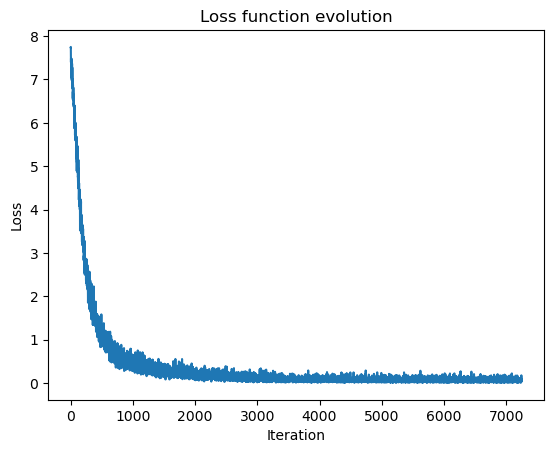

In [22]:
# Plot the loss function evolution
plt.plot(loss_reccord)
plt.title("Loss function evolution")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

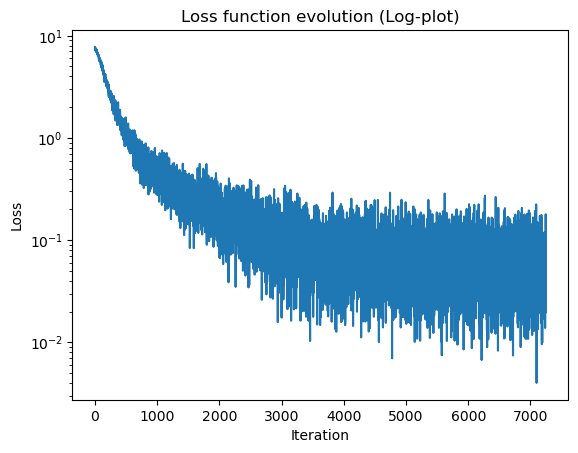

In [23]:
# Logarithmic plot of the loss function evolution
plt.semilogy(loss_reccord)
plt.title("Loss function evolution (Log-plot)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

#### Confusion matrix

We will re-run the model with the last parameters and plot the confusion matrix out of it.

In [24]:
# Initialize lists to store the true and predicted labels
true_labels = []
pred_labels = []

predict_dict = {}
# Dictionary : {file_name : label}
# Evaluate the model on the validation dataset after every epoch
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels, filenames in tqdm(val_dataloader):

        # Move data to the GPU device
        inputs = inputs.cuda()

        labels = [int(labels[i]) for i in range(len(labels))]
        # Move labels to the CUDA device
        labels = torch.tensor(labels, dtype=torch.long).cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append the predicted label to the list of the corresponding file name
        for i in range(len(filenames)):
            predict_dict[filenames[i]] = predicted[i].item()

        # Append the labels to the lists
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

100%|██████████| 19/19 [00:05<00:00,  3.48it/s]

Epoch [11/11], Validation Accuracy: 99.92%


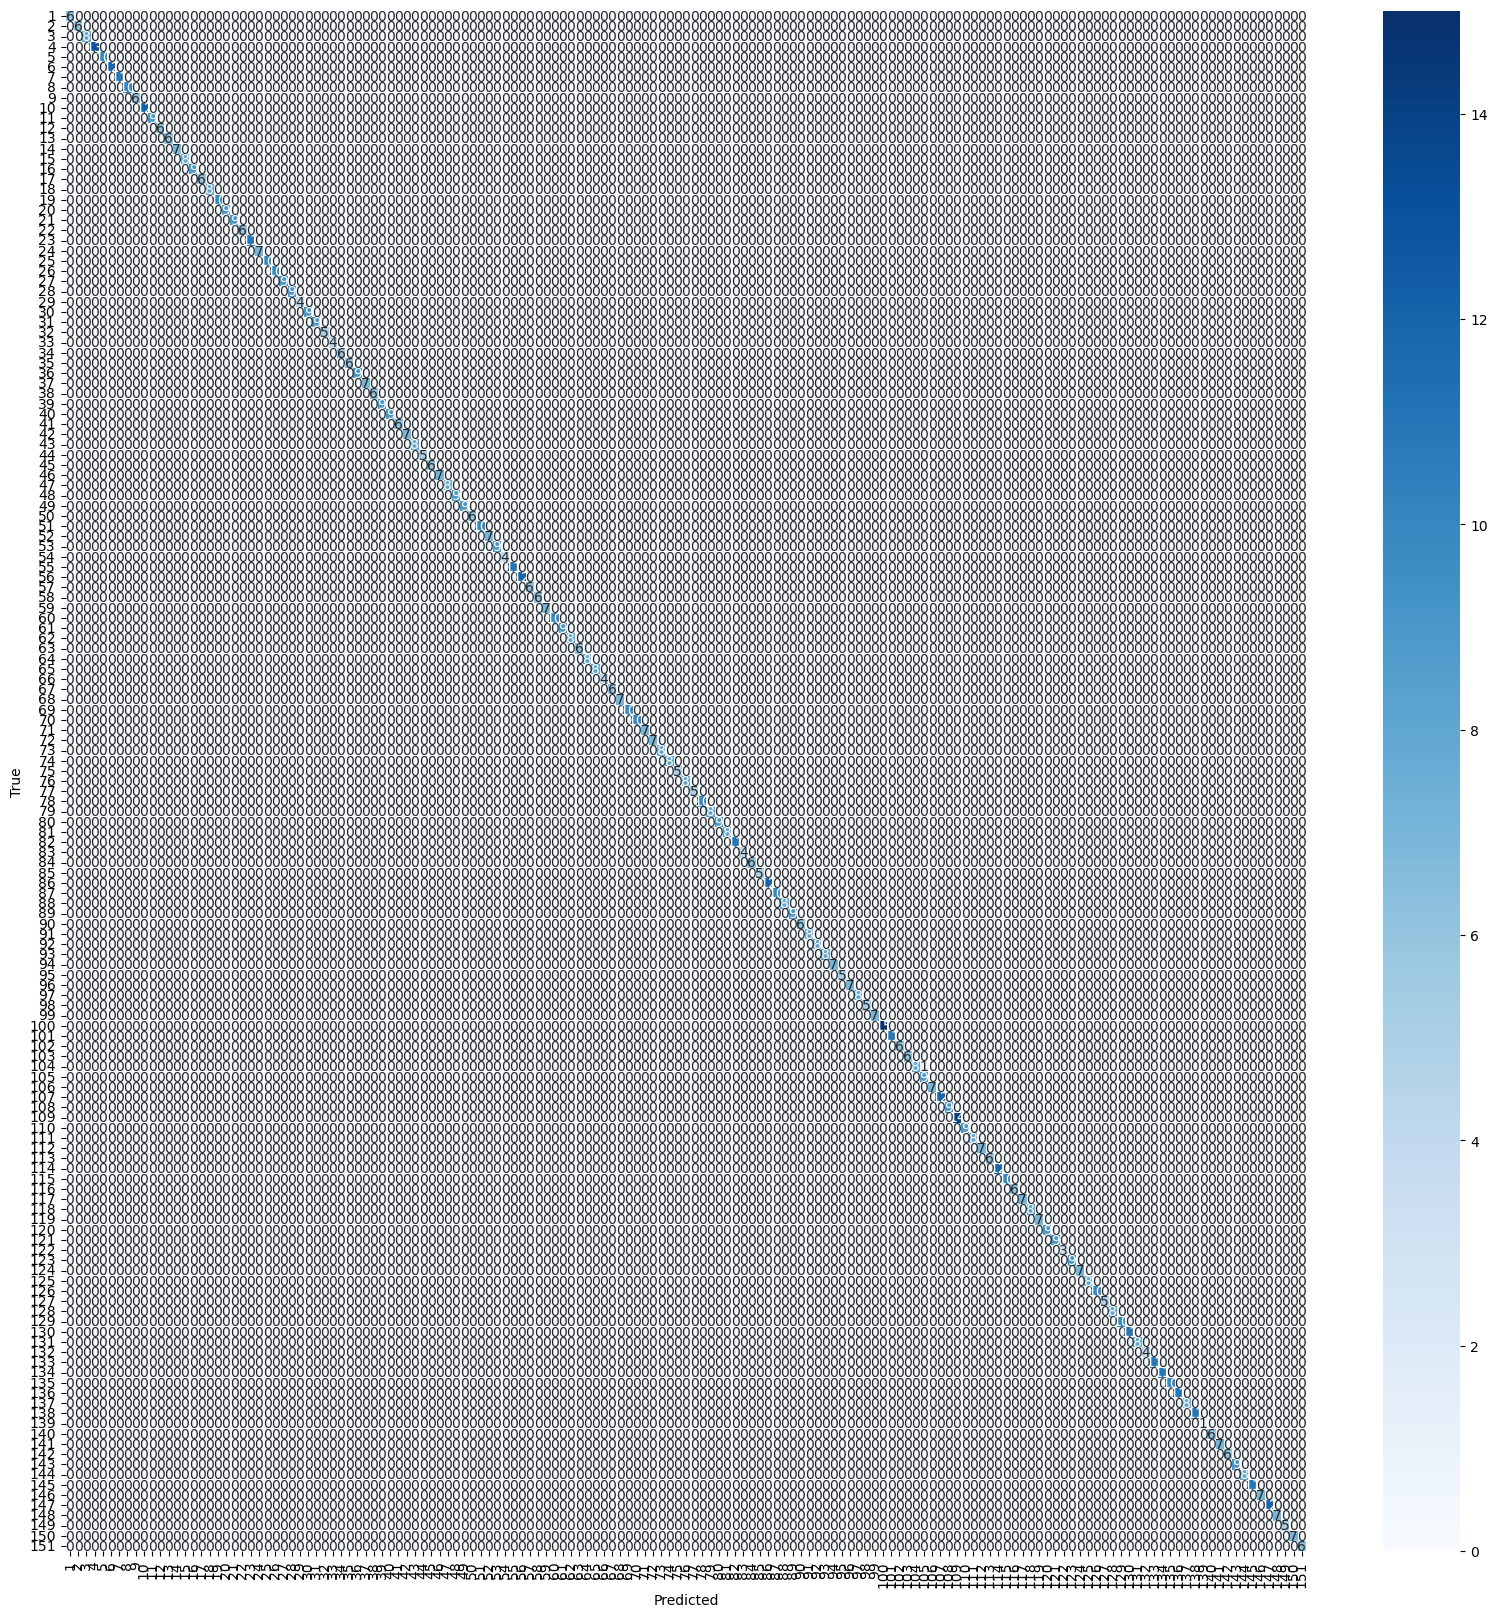

In [25]:
# Plot the confusion matrix but with the names of the pokemons instead of their labels (their labels corresponds to the number of the row/column)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=pokemon_labels_invert, yticklabels=pokemon_labels_invert)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Creating the submission file

We will first store the predictions of our model in a dictionary and then create a dataframe out of it.

In [26]:
predict_dict = {}

# Dictionary : {file_name : label}
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for inputs, _, filenames in tqdm(test_dataloader):
        # Move data to the GPU device
        inputs = inputs.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # Append the predicted label to the list of the corresponding file name
        for i in range(len(predicted)):
            # if a list exists for this file name
            if filenames[i] in predict_dict:
                predict_dict[filenames[i]].append(
                    [predicted[i].item(), pokemon_labels_invert[predicted[i].item()]])
            else:  # and pokemon name related to the label
                predict_dict[filenames[i]] = [
                    predicted[i].item(), pokemon_labels_invert[predicted[i].item()]]

  0%|          | 0/16 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


In [27]:
print(len(predict_dict))
# reorganize the dictionary in ascending order for the file names
predict_dict = dict(sorted(predict_dict.items(), key=lambda item: item[0]))
print(predict_dict)

1000
{'0.jpg': [87, 'Dewgong'], '1.jpg': [23, 'Ekans'], '10.jpg': [49, 'Venomoth'], '100.jpg': [121, 'Starmie'], '101.jpg': [68, 'Machamp'], '102.jpg': [95, 'Onix'], '103.jpg': [135, 'Jolteon'], '104.jpg': [134, 'Vaporeon'], '105.jpg': [119, 'Seaking'], '106.jpg': [102, 'Exeggcute'], '107.jpg': [102, 'Exeggcute'], '108.jpg': [81, 'Magnemite'], '109.jpg': [62, 'Poliwrath'], '11.jpg': [150, 'Mewtwo'], '110.jpg': [3, 'Venusaur'], '111.jpg': [14, 'Kakuna'], '112.jpg': [88, 'Grimer'], '113.jpg': [96, 'Drowzee'], '114.jpg': [126, 'Magmar'], '115.jpg': [8, 'Wartortle'], '116.jpg': [139, 'Omastar'], '117.jpg': [29, 'Nidoran_female'], '118.jpg': [20, 'Raticate'], '119.jpg': [134, 'Vaporeon'], '12.jpg': [36, 'Clefable'], '120.jpg': [105, 'Marowak'], '121.jpg': [42, 'Golbat'], '122.jpg': [100, 'Voltorb'], '123.jpg': [122, 'MrMime'], '124.jpg': [69, 'Bellsprout'], '125.jpg': [151, 'Mew'], '126.jpg': [37, 'Vulpix'], '127.jpg': [77, 'Ponyta'], '128.jpg': [29, 'Nidoran_female'], '129.jpg': [58, 'Grow

In [28]:
# Create csv file with filename as first column and prediction ("pokemon_id") as second column
list = []
for key in predict_dict:
    list.append([key, predict_dict[key][0]])

df = pd.DataFrame(list, columns=['filename', 'pokemon_id'])
df.to_csv('sample_submission.csv', index=False)

## Progress


After initially focusing on implementing our chosen data structure, we developed a very simple and straightforward model (2 convolutional layers, 2 fully connected layers) that helped implement optimization tricks such as the ```nn.DataParallel``` class. 
However, we decided to shift our attention onto pre-trained models, specifically exploring ```ResNet18```, ```ResNet50``` and ```EfficientNet-B0/B1/B2``` (with ```B3, B4, B5, B6, B7``` considered but deemed too resource-intensive for our GPUs).

We attenpted to modify the models, we utilized the ```model._fc``` attribute to change the last layer, aiming for a linear layer with len(classes) outputs. Unfortunately, due to CUDA memory limitations, this proved challenging. 

We then explored adjustments to external parameters such as batch_size (64, 128), learning_rate (adaptively reduced by a factor of 0.1 every 5 epochs), optimizer (Adam, with an attempted implementation of L-BFGS, a second-order optimizer for a smaller set). Through experimentation, we arrived at the following optimal parameters:

batch_size: 64
learning_rate: 0.001 (decreased by a factor of 0.1 every 5 epochs)
optimizer: Adam
loss_function: CrossEntropyLoss

We save our model to be put on the leaderboard

In [29]:
#torch.save(model.state_dict(), "/kaggle/working/model2.pth") torch.load
#torch.save(model, "/kaggle/working/model1.pth") torch.load

## Conclusion

Retrospectively, we believe we obtained quite good results when examining the initial data (including Pokemon cards, etc). However, we suspect that the model is overfitting the data because, in the end, we are training it on the same images but with different transformations.

One idea we had was to create a generative model and train it on the images we have until it generates a Pokemon image similar to the one in our dataset. We would then train our model on these generated images, we would then use the discriminative model to classify the images by changing the problem of classification into a problem of 'is this pokemon the one corresponding this image in the dataset or not?'. This would imply trying all the pokemon in the dataset and see if the model classifies the image as the pokemon we are trying (which is possible regarding the relatively small number of pokemon in the dataset).

In [30]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
model.module._conv_stem.weight 	 torch.Size([32, 3, 3, 3])
model.module._bn0.weight 	 torch.Size([32])
model.module._bn0.bias 	 torch.Size([32])
model.module._bn0.running_mean 	 torch.Size([32])
model.module._bn0.running_var 	 torch.Size([32])
model.module._bn0.num_batches_tracked 	 torch.Size([])
model.module._blocks.0._depthwise_conv.weight 	 torch.Size([32, 1, 3, 3])
model.module._blocks.0._bn1.weight 	 torch.Size([32])
model.module._blocks.0._bn1.bias 	 torch.Size([32])
model.module._blocks.0._bn1.running_mean 	 torch.Size([32])
model.module._blocks.0._bn1.running_var 	 torch.Size([32])
model.module._blocks.0._bn1.num_batches_tracked 	 torch.Size([])
model.module._blocks.0._se_reduce.weight 	 torch.Size([8, 32, 1, 1])
model.module._blocks.0._se_reduce.bias 	 torch.Size([8])
model.module._blocks.0._se_expand.weight 	 torch.Size([32, 8, 1, 1])
model.module._blocks.0._se_expand.bias 	 torch.Size([32])
model.module._blocks.0._project_conv.weight 	 torch.Size([16, 32